# Understanding "The use of multiple measurements in taxonomic problems" written by R. A. Fisher (1936)
### *IPython Notebook by Danilo J. S. Bellini*

The following Python code follows the paper conventions as much as possible and tries to use its raw data to re-create the tables and other numbers from the paper. This notebook can be seen at least as a guide on understanding that historical article that defined the Fisher Linear Discriminant and published the famous Iris dataset. Actually, this notebook includes several other stuff related to the paper and the dataset, most of them found while trying to grasp what Fisher wrote.

If you like this publication, please watch/star my scientific literature notebooks repository: https://github.com/danilobellini/scientific-literature

We're going to use the following Python libraries: Numpy, Matplotlib, Pandas and Scipy

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats, spatial
%matplotlib inline

# I. Discriminant functions

Proposal:

- There are several characters/features/measurements $x_1$, ..., $x_s$
- Find a **linear** function of these *by which the populations are best discriminated*!

How can such a function discriminate?

- Each measurement vector is projected onto a weight vector $\pmb{\lambda}$ for discrimination
- The discriminant function is a hyperplane, whose displacement (the $X$ value to be used as a threshold between a given pair of classes) should also be found

Use of that idea had already been made by other authors, e.g. on finding sex differences in mandible measurements, following Fisher's suggestion.

Let's create an example with random data to create a graphical idea of how this "dimensionality reduction to a line" procedure should work.

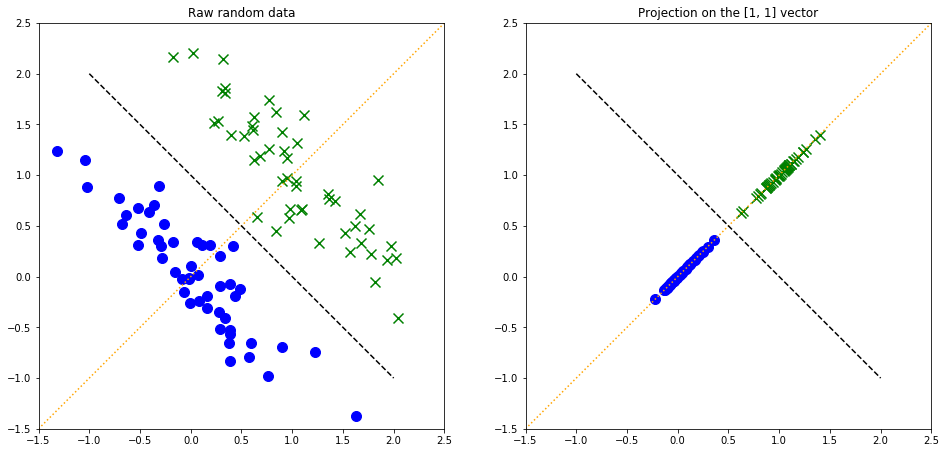

In [2]:
np.random.seed(5)

data1 = np.random.multivariate_normal([0, 0], [[.3, -.25], [-.25, .3]], 50)
data2 = np.random.multivariate_normal([1, 1], [[.3, -.25], [-.25, .3]], 50)
pdata1 = data1 @ [.5, .5]
pdata2 = data2 @ [.5, .5]

ax1, ax2 = plt.subplots(1, 2, figsize=(16, 8))[1]

ax1.plot([-1.5, 2.5], [-1.5, 2.5], ls=":", color="orange")
ax1.plot([-1, 2], [2, -1], ls="--", color="black")
ax1.scatter(*data1.T, s=100, marker="o", color="blue")
ax1.scatter(*data2.T, s=100, marker="x", color="green")
ax1.set(title="Raw random data",
        xlim=[-1.5, 2.5], ylim=[-1.5, 2.5], aspect="equal")

ax2.plot([-1.5, 2.5], [-1.5, 2.5], ls=":", color="orange")
ax2.plot([-1, 2], [2, -1], ls="--", color="black")
ax2.scatter(pdata1, pdata1, 100, marker="o", color="blue")
ax2.scatter(pdata2, pdata2, 100, marker="x", color="green")
ax2.set(title="Projection on the [1, 1] vector",
        xlim=[-1.5, 2.5], ylim=[-1.5, 2.5], aspect="equal");

The goal is to find the best line to project the data on. Try to see in that plot what would happen if you project the data directly to any raw axis, without the 45 degrees rotation. The black dashed line is the discriminator that should be a hyperplane in higher dimensions, and the orange dotted line is the line we're projecting the data onto.

## The Iris dataset

- Collected by Edgar Anderson
- Published by Fisher in his paper
- There are several versions of this data (e.g. UCI, Scikit-Learn, Wikipedia),
  most of them differs from the original data
  (There's even a publication
   [Will the real iris data please stand up?](http://ieeexplore.ieee.org/document/771092/)
   pointing out the replication errors)
- 3 Iris species: *I. setosa*, *I. versicolor* and *I. virginica*

Let's see these flowers (images from Wikipedia):

|Iris setosa                           |Iris versicolor                               |Iris virginica                              |
|:------------------------------------:|:--------------------------------------------:|:------------------------------------------:|
|![Iris setosa](images/Iris_setosa.jpg)|![Iris versicolor](images/Iris_versicolor.jpg)|![Iris virginica](images/Iris_virginica.jpg)|

The `iris.csv` file has the Iris data as published by Fisher, but as a single table with snake_case column and class names. Let's see the first row from each class:

In [3]:
iris = pd.read_csv("iris.csv")
iris.loc[(0,50,100),:]

,sepal_length,sepal_width,petal_length,petal_width,name
0,5.1,3.5,1.4,0.2,setosa
50,7.0,3.2,4.7,1.4,versicolor
100,6.3,3.3,6.0,2.5,virginica


This data has $n = 50$ rows for each class, one row for each plant. All measurements are given in centimeters, as collected by E. Anderson. The full dataset was published as the Table I in the Fisher's article.

### Table I - Iris dataset ($cm$)

In [4]:
table1 = (iris.pivot(iris.index % 50, columns="name")
              .sort_index(axis=1, level=1, sort_remaining=False)
              .swaplevel(0, 1, axis=1))
table1

name       setosa                                        versicolor  \
     sepal_length sepal_width petal_length petal_width sepal_length   
0             5.1         3.5          1.4         0.2          7.0   
1             4.9         3.0          1.4         0.2          6.4   
2             4.7         3.2          1.3         0.2          6.9   
3             4.6         3.1          1.5         0.2          5.5   
4             5.0         3.6          1.4         0.2          6.5   
5             5.4         3.9          1.7         0.4          5.7   
6             4.6         3.4          1.4         0.3          6.3   
7             5.0         3.4          1.5         0.2          4.9   
8             4.4         2.9          1.4         0.2          6.6   
9             4.9         3.1          1.5         0.1          5.2   
10            5.4         3.7          1.5         0.2          5.0   
11            4.8         3.4          1.6         0.2          5.9   
12            4.8         3.0          1.4         0.1          6.0   
13            4.3         3.0          1.1         0.1          6.1   
14            5.8         4.0          1.2         0.2          5.6   
15            5.7         4.4          1.5         0.4          6.7   
16            5.4         3.9          1.3         0.4          5.6   
17            5.1         3.5          1.4         0.3          5.8   
18            5.7         3.8          1.7         0.3          6.2   
19            5.1         3.8          1.5         0.3          5.6   
20            5.4         3.4          1.7         0.2          5.9   
21            5.1         3.7          1.5         0.4          6.1   
22            4.6         3.6          1.0         0.2          6.3   
23            5.1         3.3          1.7         0.5          6.1   
24            4.8         3.4          1.9         0.2          6.4   
25            5.0         3.0          1.6         0.2          6.6   
26            5.0         3.4          1.6         0.4          6.8   
27            5.2         3.5          1.5         0.2          6.7   
28            5.2         3.4          1.4         0.2          6.0   
29            4.7         3.2          1.6         0.2          5.7   
30            4.8         3.1          1.6         0.2          5.5   
31            5.4         3.4          1.5         0.4          5.5   
32            5.2         4.1          1.5         0.1          5.8   
33            5.5         4.2          1.4         0.2          6.0   
34            4.9         3.1          1.5         0.2          5.4   
35            5.0         3.2          1.2         0.2          6.0   
36            5.5         3.5          1.3         0.2          6.7   
37            4.9         3.6          1.4         0.1          6.3   
38            4.4         3.0          1.3         0.2          5.6   
39            5.1         3.4          1.5         0.2          5.5   
40            5.0         3.5          1.3         0.3          5.5   
41            4.5         2.3          1.3         0.3          6.1   
42            4.4         3.2          1.3         0.2          5.8   
43            5.0         3.5          1.6         0.6          5.0   
44            5.1         3.8          1.9         0.4          5.6   
45            4.8         3.0          1.4         0.3          5.7   
46            5.1         3.8          1.6         0.2          5.7   
47            4.6         3.2          1.4         0.2          6.2   
48            5.3         3.7          1.5         0.2          5.1   
49            5.0         3.3          1.4         0.2          5.7   

name                                         virginica              \
     sepal_width petal_length petal_width sepal_length sepal_width   
0            3.2          4.7         1.4          6.3         3.3   
1            3.2          4.5         1.5          5.8         2.7   
2            3.1          4

But... what are sepals and petals?

| | |
|-|-|
|![Petal and sepal](images/Petal-sepal.jpg)|![Iris petal and Sepal](images/iris_petal_sepal.png)|

(Flower images from Wikipedia and the [Sebastian Raschka article on LDA](http://sebastianraschka.com/Articles/2014_python_lda.html))

The image at the left hand side isn't an Iris... but it helps on thinking: the sepal is somewhat "external", they're the calyx that supports the petals, whereas the petal is the "internal" stuff being supported/protected. Is that information enough for you to collect sepal and petal measurements in centimeters?

# II. Arithmetical procedure

Given that:

- $x_1$ is the sepal length
- $x_2$ is the sepal width
- $x_3$ is the petal length
- $x_4$ is the petal width

What linear function $X(x_1, x_2, x_3, x_4)$:

$$X = \lambda_1 x_1 + \lambda_2 x_2 + \lambda_3 x_3 + \lambda_4 x_4$$

will maximize the *ratio of the difference between the specific means to the standard deviations within species*? (i.e., what's the best discriminant function?)

That $X$ function can be written as an inner product:

$$
\pmb{\lambda} = \left[ \begin{matrix} \lambda_1 \\ \lambda_2 \\ \lambda_3 \\ \lambda_4 \end{matrix} \right]
\quad
\mathbf{x} = \left[ \begin{matrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{matrix} \right]
\quad
X = \pmb{\lambda}^T \mathbf{x} = \sum_{p=1}^{4} \lambda_p x_p
$$

At first, Fisher is concerned with this pair of groups/classes: *Iris setosa* and *Iris versicolor*.

Maximizing the square root of a positive quantity is the same to maximizing such quantity, as the square root is a monotonically increasing function. That is, maximizing the standard deviation and maximizing the variance are the same thing. That said, we'll be dealing with variances and sums of squares instead of standard deviations.

Our goal here is to maximize this ratio:

$$\frac{{variability}_{between}}{{variability}_{within}} \propto \frac{D^2}{S}$$

Where $D^2$ should be seen as a between-group measure of variability and $S$ as a within-group measure of variability. The underlying reason for using a ratio like that can be understood by looking to the following normal data plots:

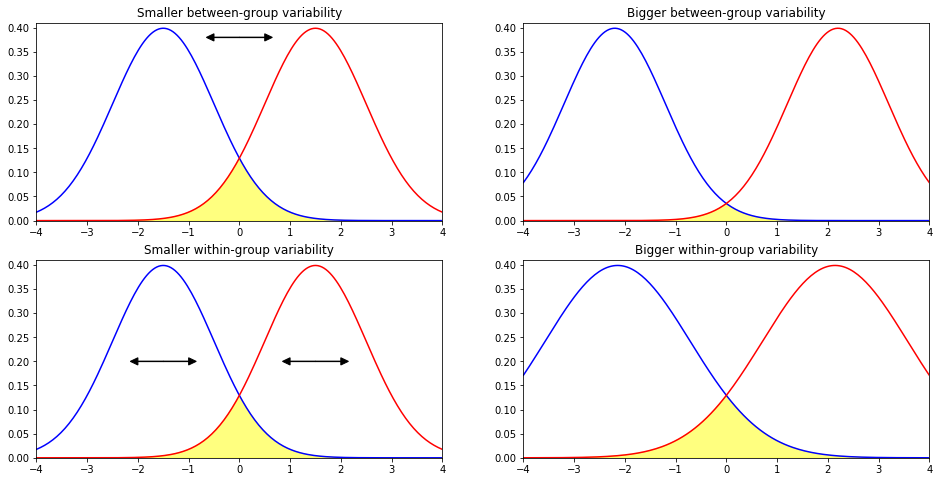

In [5]:
x = np.linspace(-4, 4, 200)
pdfs = np.vstack([stats.norm.pdf(x + 1.5), stats.norm.pdf(x - 1.5)])
pdfs_b = np.vstack([stats.norm.pdf(x + 2.2), stats.norm.pdf(x - 2.2)])
pdfs_w = np.vstack([stats.norm.pdf(.7 * x + 1.5),
                    stats.norm.pdf(.7 * x - 1.5)])

(ax1, ax2), (ax3, ax4) = plt.subplots(2, 2, figsize=(16, 8))[1]

ax1.plot(x, pdfs[0], "b", x, pdfs[1], "r")
ax1.fill(x, pdfs.min(axis=0), alpha=.5, color="yellow")
ax1.arrow(0, .38, .5, 0, head_width=.015, head_length=.15, fc="k", ec="k")
ax1.arrow(0, .38, -.5, 0, head_width=.015, head_length=.15, fc="k", ec="k")
ax1.set(title="Smaller between-group variability",
        xlim=(x[0], x[-1]), ylim=(0, .41))

ax2.plot(x, pdfs_b[0], "b", x, pdfs_b[1], "r")
ax2.fill(x, pdfs_b.min(axis=0), alpha=.5, color="yellow")
ax2.set(title="Bigger between-group variability",
        xlim=(x[0], x[-1]), ylim=(0, .41))

ax3.plot(x, pdfs[0], "b", x, pdfs[1], "r")
ax3.fill(x, pdfs.min(axis=0), alpha=.5, color="yellow")
ax3.arrow(-1.5, .2, .5, 0, head_width=.015, head_length=.15, fc="k", ec="k")
ax3.arrow(-1.5, .2, -.5, 0, head_width=.015, head_length=.15, fc="k", ec="k")
ax3.arrow(1.5, .2, .5, 0, head_width=.015, head_length=.15, fc="k", ec="k")
ax3.arrow(1.5, .2, -.5, 0, head_width=.015, head_length=.15, fc="k", ec="k")
ax3.set(title="Smaller within-group variability",
        xlim=(x[0], x[-1]), ylim=(0, .41))

ax4.plot(x, pdfs_w[0], "b", x, pdfs_w[1], "r")
ax4.fill(x, pdfs_w.min(axis=0), alpha=.5, color="yellow")
ax4.set(title="Bigger within-group variability",
        xlim=(x[0], x[-1]), ylim=(0, .41));

The best scenario for data discrimination is the one where:

- The between-group variability is bigger
- The within-group variability is smaller

And that's what the ratio maximization is all about.

## ANOVA and the $F$-ratio

Perhaps the best way to think about that $D^2/S$ ratio and the further analysis Fisher provides is to think we're doing an one-way ANOVA for the hypothesis that there are two distinct means (two populations), and then we calculate the $F$-ratio from the univariate results of $X$ as our random variable assuming we know the $\pmb{\lambda}$ vector direction.

For a given $\pmb{\lambda}$ direction, we get the values of $X = \pmb{\lambda}^T\mathbf{x}$. Using that information, suppose we want to test this:

| | |
|:-:|:-|
|$H_0$|$\mu_X^{(setosa)} = \mu_X^{(versicolor)}$|
|$H_A$|$\mu_X^{(setosa)} \ne \mu_X^{(versicolor)}$|

Where $\mu_X^{(g)}$ is the population mean of $X^{(g)}$. To test if we should reject the null hypothesis $H_0$ for a given probability threshold, we find the value of the $F$-test statistic:

$$
\begin{array}{rcl} \displaystyle
F = \frac{MS_{between}}{MS_{within}}
   & \displaystyle = & \displaystyle
\frac{\left. SS_{between} \right/ df_{between}}
     {\left. SS_{within} \right/ df_{within}}
\\ & \displaystyle = & \displaystyle
\frac{\displaystyle \left. \sum_g n_g \left( \bar{X}^{(g)} - \bar{X} \right)^2 \right/ df_{between}}
     {\displaystyle \left. \sum_g \sum_{i=1}^{n_g} \left( X_i^{(g)}-\bar{X}^{(g)} \right)^2 \right/ df_{within}}
\end{array}
$$

There are only 2 groups for these sums indexed by $g$, and $n_g = 50 = n$ for both of them.

For a given $\alpha$-level (probability threshold) for rejecting the null and the numbers of degrees of freedom, we can get an $F$-critical value from the Snedecor-Fisher distribution.

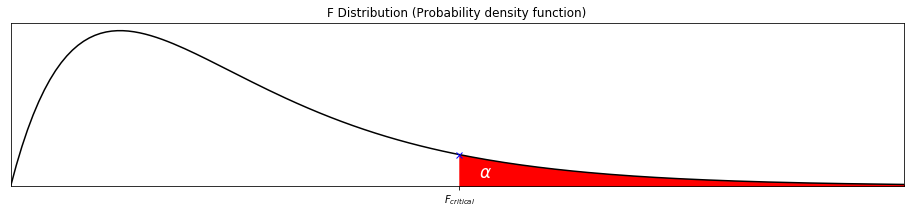

In [6]:
x = np.linspace(0, 5, 200)
with np.errstate(divide="ignore"):
    y = stats.f.pdf(x, 4, 95)
threshold = 2
selector = x >= threshold
xs, ys = x[selector], y[selector]

ax = plt.subplots(1, 1, figsize=(16, 3))[1]
ax.plot(x, y, "k", xs[0], ys[0], "bx")
ax.fill_between(xs, 0, ys, color="red")
ax.set(title="F Distribution (Probability density function)",
       xlim=(0, 4), ylim=(0, y.max() * 1.05), xticks=[xs[0]], xticklabels=["$F_{critical}$"], yticks=[])
ax.text(threshold + .1, .04, r"$\alpha$", color="white", size=17);

$F_{critical}$ is determined from an $(\alpha, df_{between}, df_{within})$ triple. The test is:

- When $F > F_{critical}$, we reject the null (the means are distinct)
- Otherwise, we retain the null (we can't say the means are distinct)

Actually, there's no $\alpha$ nor an ANOVA nor a hypothesis testing going on here. But we've got an $F$ that is a function of $\pmb{\lambda}$, and we know that this $F$ statistic should be as big as possible to ensure the means are distinct even for the strictiest $\alpha$ value. So, instead of doing an ANOVA, we just want to find the $\pmb{\lambda}$ vector that maximizes this F-ratio.

PS: Likewise, one can think on the Student's $t$-test instead of the $F$-test shown here, as this ANOVA was just applied to a pair of groups. This $F$ statistic is the square of the $t$ statistic one would get.


## Between-group variability

Regarding the chosen pair of groups/classes, as their sample sizes are the same, their grand mean is:

$$\bar{X} = \frac{\bar{X}^{(setosa)} + \bar{X}^{(versicolor)}}{2}$$

The variance of the means of $X$ for each group is given by the following $MS_{between}$ (Mean of Squares):

$$
MS_{between} = \frac{SS_{between}}{df_{between}} =
n \frac{\left(\bar{X}^{(setosa)} - \bar{X}\right)^2 + \left(\bar{X}^{(versicolor)} - \bar{X}\right)^2}{df_{between}}
$$

Where $n = 50$ is the number of samples for each group, and $df_{between}$ is the number of degrees of freedom between groups (that will be seen with more details afterwards).

Let's focus on the $SS_{between}$ (Sum of Squares). That's proportional to the square of the difference between the means, since its raw sum of squares is:

$$
\begin{array}{rcl} \displaystyle
\left(\bar{X}^{(setosa)} - \bar{X}\right)^2 + \left(\bar{X}^{(versicolor)} - \bar{X}\right)^2
   & \displaystyle = & \displaystyle
\left(\bar{X}^{(setosa)} - \frac{\bar{X}^{(setosa)} + \bar{X}^{(versicolor)}}{2}\right)^2 + \left(\bar{X}^{(versicolor)} - \frac{\bar{X}^{(setosa)} + \bar{X}^{(versicolor)}}{2}\right)^2
\\ & \displaystyle = & \displaystyle
\left(\frac{\bar{X}^{(setosa)} - \bar{X}^{(versicolor)}}{2}\right)^2 + \left(\frac{\bar{X}^{(versicolor)} - \bar{X}^{(setosa)}}{2}\right)^2
\\ & \displaystyle = & \displaystyle
\frac{1}{4} \left(\bar{X}^{(setosa)} - \bar{X}^{(versicolor)}\right)^2 + \frac{1}{4} \left(\bar{X}^{(versicolor)} - \bar{X}^{(setosa)}\right)^2
\\ & \displaystyle = & \displaystyle
\frac{1}{2} \left(\bar{X}^{(versicolor)} - \bar{X}^{(setosa)}\right)^2
\end{array}
$$

So,

$$SS_{between} = \frac{n}{2} \left(\bar{X}^{(versicolor)} - \bar{X}^{(setosa)}\right)^2 = 25 D^2$$

Fisher tells he's using $D^2 = \left(\bar{X}^{(versicolor)} - \bar{X}^{(setosa)}\right)^2$ as the between-class variability measure when he's looking for the $\pmb{\lambda}$ direction, but the constants we're seeing here are required later on, in order to understand his further analysis.

## Value of $D$ as a function of $\pmb{\lambda}$

Let $d_p$ be the mean differences between groups/classes for each measurement, as shown in the Table II:

$$d_p = \bar{x}_p^{(versicolor)} - \bar{x}_p^{(setosa)}$$

Or, using matrices (be careful: every one of these is a lowercase $x$):

$$
\mathbf{d} = \left[ \begin{matrix} d_1 \\ d_2 \\ d_3 \\ d_4 \end{matrix} \right]
           = \left[ \begin{matrix} \bar{x}_1^{(versicolor)} \\ \bar{x}_2^{(versicolor)} \\ \bar{x}_3^{(versicolor)} \\ \bar{x}_4^{(versicolor)} \end{matrix} \right]
           - \left[ \begin{matrix} \bar{x}_1^{(setosa)} \\ \bar{x}_2^{(setosa)} \\ \bar{x}_3^{(setosa)} \\ \bar{x}_4^{(setosa)} \end{matrix} \right]
           = \mathbf{\bar{x}^{(versicolor)}} - \mathbf{\bar{x}^{(setosa)}}
$$

### Table II - Observed means for two species and their difference ($cm$)

In [7]:
table2 = pd.DataFrame(table1.mean().unstack(0).reindex(iris.columns[:-1]),
                      columns=["versicolor", "setosa"]
                     ).assign(diff=lambda tbl: tbl.versicolor - tbl.setosa)
table2

,versicolor,setosa,diff
sepal_length,5.936,5.006,0.930
sepal_width,2.770,3.428,-0.658
petal_length,4.260,1.462,2.798
petal_width,1.326,0.246,1.080


The *diff* column has the $d_p$ values. We still need differences regarding the function $X$, not just differences based on the measurements themselves.

The difference between the *means* of $X$ in the two species is given by $D$:

$$
\begin{array}{rcl}
\displaystyle D
   & \displaystyle = & \displaystyle
     \bar{X}^{(versicolor)} - \bar{X}^{(setosa)}
\\ & \displaystyle = & \displaystyle
     E \left( \sum_{p=1}^{4} \lambda_p x_p^{(versicolor)} \right) - E \left( \sum_{q=1}^{4} \lambda_q x_q^{(setosa)} \right)
\\ & \displaystyle = & \displaystyle
     \sum_{p=1}^{4} \lambda_p E \left( x_p^{(versicolor)} \right) - \sum_{q=1}^{4} \lambda_q E \left( x_q^{(setosa)} \right)
\\ & \displaystyle = & \displaystyle
     \sum_{p=1}^{4} \lambda_p \bar{x}_p^{(versicolor)} - \sum_{q=1}^{4} \lambda_q \bar{x}_q^{(setosa)}
\\ & \displaystyle = & \displaystyle
     \sum_{p=1}^{4} \lambda_p \bar{x}_p^{(versicolor)} - \lambda_p \bar{x}_p^{(setosa)}
\\ & \displaystyle = & \displaystyle
     \sum_{p=1}^{4} \lambda_p \left( \bar{x}_p^{(versicolor)} - \bar{x}_p^{(setosa)} \right)
\\ & \displaystyle = & \displaystyle
     \sum_{p=1}^{4} \lambda_p d_p
\\ & \displaystyle = & \displaystyle
     \pmb{\lambda}^T \mathbf{d}
\end{array}
$$

Where $E(\cdot)$ is the expectation operator. This $D$ is shown in the Fisher's article directly as:

$$D = \lambda_1 d_1 + \lambda_2 d_2 + \lambda_3 d_3 + \lambda_4 d_4$$

We want to find the $\pmb{\lambda}$ values what maximizes a somehow "normalized" $D$, i.e., we want to maximize that distance in standard deviations, not in centimeters. That's enough for the F-ratio numerator for now, let's see what's going on with the denominator.

## Pooled variance

The within-group variances for each group might not be the same, but to create a combined variance measure for them we're going to assume they are the same, though their means are different. That result is called *pooled variance* and appears in the denominator of the F-ratio:

$$
\begin{array}{rcl} \displaystyle
MS_{within} = \frac{SS_{within}}{df_{within}}
   & \displaystyle = & \displaystyle
\frac{\displaystyle \sum_g \sum_{i=1}^{n_g} \left( X_i^{(g)}-\bar{X}^{(g)} \right)^2}
     {\displaystyle df_{within}}
\end{array}
$$

This assumption is specific to the pooled variance to be used as a within-group variability measure. If it was a strong assumption, the discriminant threshold would always be exactly in the middle of the means of $X$.

## Within-group variability

Let's split on each group/class the sum of squares regarding the within-group variability:

$$SS_{within} = \sum_g SS_g$$

The sum of squares for a single group $g$ is:

$$
\begin{array}{rcl} \displaystyle
SS_g
   & \displaystyle = & \displaystyle
\sum_{i=1}^{n_g} \left( X_i^{(g)}-\bar{X}^{(g)} \right)^2
\\ & \displaystyle = & \displaystyle
\sum_{i=1}^{n_g} \left(   X_i^{(g)} X_i^{(g)}
                        - X_i^{(g)} \bar{X}^{(g)}
                        - \bar{X}^{(g)} X_i^{(g)}
                        + \bar{X}^{(g)} \bar{X}^{(g)}
                 \right)
\\ & \displaystyle = & \displaystyle
\sum_{i=1}^{n_g}
  \left[   (\pmb{\lambda}^T \mathbf{x}_i^{(g)}) (\pmb{\lambda}^T \mathbf{x}_i^{(g)})
         - (\pmb{\lambda}^T \mathbf{x}_i^{(g)}) (\pmb{\lambda}^T \mathbf{\bar{x}}^{(g)})
         - (\pmb{\lambda}^T \mathbf{\bar{x}}^{(g)}) (\pmb{\lambda}^T \mathbf{x}_i^{(g)})
         + (\pmb{\lambda}^T \mathbf{\bar{x}}^{(g)}) (\pmb{\lambda}^T \mathbf{\bar{x}}^{(g)})
  \right]
\\ & \displaystyle = & \displaystyle
\sum_{i=1}^{n_g}
  \left[   (\pmb{\lambda}^T \mathbf{x}_i^{(g)}) ({\mathbf{x}_i^{(g)}}^T \pmb{\lambda})
         - (\pmb{\lambda}^T \mathbf{x}_i^{(g)}) ({\mathbf{\bar{x}}^{(g)}}^T \pmb{\lambda})
         - (\pmb{\lambda}^T \mathbf{\bar{x}}^{(g)}) ({\mathbf{x}_i^{(g)}}^T \pmb{\lambda})
         + (\pmb{\lambda}^T \mathbf{\bar{x}}^{(g)}) ({\mathbf{\bar{x}}^{(g)}}^T \pmb{\lambda})
  \right]
\\ & \displaystyle = & \displaystyle
\sum_{i=1}^{n_g}
  \left[   \pmb{\lambda}^T \mathbf{x}_i^{(g)} {\mathbf{x}_i^{(g)}}^T \pmb{\lambda}
         - \pmb{\lambda}^T \mathbf{x}_i^{(g)} {\mathbf{\bar{x}}^{(g)}}^T \pmb{\lambda}
         - \pmb{\lambda}^T \mathbf{\bar{x}}^{(g)} {\mathbf{x}_i^{(g)}}^T \pmb{\lambda}
         + \pmb{\lambda}^T \mathbf{\bar{x}}^{(g)} {\mathbf{\bar{x}}^{(g)}}^T \pmb{\lambda}
  \right]
\\ & \displaystyle = & \displaystyle
\pmb{\lambda}^T \sum_{i=1}^{n_g}
  \left[ \mathbf{x}_i^{(g)} {\mathbf{x}_i^{(g)}}^T
       - \mathbf{x}_i^{(g)} {\mathbf{\bar{x}}^{(g)}}^T
       - \mathbf{\bar{x}}^{(g)} {\mathbf{x}_i^{(g)}}^T
       + \mathbf{\bar{x}}^{(g)} {\mathbf{\bar{x}}^{(g)}}^T
  \right] \pmb{\lambda}
\\ & \displaystyle = & \displaystyle
\pmb{\lambda}^T \sum_{i=1}^{n_g}
  \left[ \left( \mathbf{x}_i^{(g)} - {\mathbf{\bar{x}}^{(g)}} \right)
         \left( \mathbf{x}_i^{(g)} - {\mathbf{\bar{x}}^{(g)}} \right)^T
  \right] \pmb{\lambda}
\\ & \displaystyle = & \displaystyle
\pmb{\lambda}^T (n_g - 1) \mathbf{Q}^{(g)} \pmb{\lambda}
\end{array}
$$

Where

$$
\mathbf{Q}^{(g)} = \frac{1}{n_g - 1} \sum_{i=1}^{n_g}
  \left[ \left( \mathbf{x}_i^{(g)} - {\mathbf{\bar{x}}^{(g)}} \right)
         \left( \mathbf{x}_i^{(g)} - {\mathbf{\bar{x}}^{(g)}} \right)^T
  \right]
$$

is the unbiased covariance matrix estimator (sample covariance matrix) for the $\mathbf{x}_i^{(g)}$ random vectors (i.e., the covariance matrix calculated from the raw measurements/features table for the group $g$).

Therefore the within-group sum of squares is:

$$
\begin{array}{rcl} \displaystyle
SS_{within}
   & \displaystyle = & \displaystyle
\sum_g \pmb{\lambda}^T (n_g - 1) \mathbf{Q}^{(g)} \pmb{\lambda}
\\ & \displaystyle = & \displaystyle
\pmb{\lambda}^T \left[ \sum_g (n_g - 1) \mathbf{Q}^{(g)} \right] \pmb{\lambda}
\\ & \displaystyle = & \displaystyle
\pmb{\lambda}^T \left[ (n - 1) \sum_g \mathbf{Q}^{(g)} \right] \pmb{\lambda}
\\ & \displaystyle = & \displaystyle
\pmb{\lambda}^T \mathbf{S} \pmb{\lambda}
\end{array}
$$

As $n = n_g = 50$ is the same for all groups. The new "scatter" matrix $\mathbf{S}$ is:

$$
\mathbf{S} = (n - 1) \left( \mathbf{Q}^{(versicolor)} + \mathbf{Q}^{(setosa)} \right) = \left[ \begin{matrix}
S_{1 1} & S_{1 2} & S_{1 3} & S_{1 4} \\
S_{2 1} & S_{2 2} & S_{2 3} & S_{2 4} \\
S_{3 1} & S_{3 2} & S_{3 3} & S_{3 4} \\
S_{4 1} & S_{4 2} & S_{4 3} & S_{4 4}
\end{matrix} \right]
$$

And the $\pmb{\lambda}^T \mathbf{S} \pmb{\lambda}$ matrix multiplication can be written as:

$$SS_{within} = \sum_{p=1}^{4} \sum_{q=1}^{4} \lambda_p \lambda_q S_{p q}$$

That's why Fisher said the [pooled] variance within species is proportional to this $S = SS_{within}$, our measure of within-group variability. The actual values of the $\mathbf{S}$ matrix are shown in the Table III.


### Table III - Sums of squares and products of four measurements, within species ($cm^2$)

In [8]:
n = table1.shape[0]
table3 = (table1.setosa.cov() + table1.versicolor.cov()) * (n - 1)
table3

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,19.1434,9.0356,9.7634,3.2394
sepal_width,9.0356,11.8658,4.6232,2.4746
petal_length,9.7634,4.6232,12.2978,3.8794
petal_width,3.2394,2.4746,3.8794,2.4604


That table has the *sums of squares and products of deviations from the specific means* Fisher talks about. The "products" that aren't "squares" are covariances. That might be quite confusing, as there weren't any variable besides $X^{(g)}$ when the $S = SS_{within}$ was defined, it was just a univariate analysis. Were did the covariances come from?

What defines the covariance matrices are the $\mathbf{x}^{(g)}$ vectors, and the fact that:

$$var \left( X^{(g)} \right) = var \left( \pmb{\lambda}^T \mathbf{x}^{(g)} \right) = \pmb{\lambda}^T var \left( \mathbf{x}^{(g)} \right) \pmb{\lambda}$$

We already used that result to find the $SS_g$ values, but using the $\mathbf{Q}^{(g)}$ sample covariance matrix instead of population parameters.

## $F$-ratio as a function of $\pmb{\lambda}$

Let's join what we've found until now.

$$
F = \frac{\left. SS_{between} \right/ df_{between}}
         {\left. SS_{within} \right/ df_{within}}
=
\frac{\displaystyle \left. \frac{n}{2} D^2 \right/ df_{between}}
     {\displaystyle \left. S \right/ df_{within}}
=
\frac{\displaystyle n \, df_{within}}
     {\displaystyle 2 \, df_{between}}
\frac{\displaystyle D^2}
     {\displaystyle S}
=
m
\frac{\displaystyle D^2}
     {\displaystyle S}
$$

What we want to do is to find the $\pmb{\lambda}$ vector that maximizes that statistic. Quoting Fisher:

> The particular linear function which best discriminates the two species will be one for which the ratio $D^2/S$ is greatest, by variation of the four coefficients $\lambda_1$, $\lambda_2$, $\lambda_3$ and $\lambda_4$ independently.

The $m = \left. n \, df_{within} \right/ \left( 2 \, df_{between} \right)$ is a constant value, it doesn't make any difference on the $\lambda_p$ values that maximizes that ratio.

For each $\lambda_p$, the partial derivative of $F$ is:

$$
\begin{array}{rcl} \displaystyle
\frac{\partial F}{\partial \lambda_p}
   &  \displaystyle = &  \displaystyle
\frac{m}{S^2} \left[ \left( \frac{\partial}{\partial \lambda_p} D^2 \right) S - D^2 \left( \frac{\partial}{\partial \lambda_p} S \right) \right]
\\ &  \displaystyle = &  \displaystyle
\frac{m}{S^2} \left[ 2 D \frac{\partial D}{\partial \lambda_p} S - D^2 \frac{\partial S}{\partial \lambda_p} \right]
\\ &  \displaystyle = &  \displaystyle
m \frac{D}{S^2} \left[ 2 S \frac{\partial D}{\partial \lambda_p} - D \frac{\partial S}{\partial \lambda_p} \right]
\end{array}
$$

Zeroing the $D^2/S$ gradient (or the $\nabla F$) to find the maximum value of the ratio, we get this system of equations:

$$
\frac{D}{S^2} \left[ 2 S \frac{\partial D}{\partial \lambda_p} - D \frac{\partial S}{\partial \lambda_p} \right] = 0
, \quad \forall p \in \{1, 2, 3, 4\}
$$

We can assume that $D \ne 0$, since we want to maximize the ratio, not to minimize it. Therefore:

$$
2 S \frac{\partial D}{\partial \lambda_p} - D \frac{\partial S}{\partial \lambda_p} = 0
, \quad \forall p \in \{1, 2, 3, 4\}
$$

Or:

$$
\frac{1}{2} \frac{\partial S}{\partial \lambda_p} = \frac{S}{D} \frac{\partial D}{\partial \lambda_p}
, \quad \forall p \in \{1, 2, 3, 4\}
$$

Let's find the partial derivatives of $D$:

$$
\require{cancel}
\begin{array}{rcl} \displaystyle
\frac{\partial D}{\partial \lambda_p}
   & \displaystyle = & \displaystyle
\frac{\partial}{\partial \lambda_p} \sum_{a=1}^4 \lambda_a d_a
\\ & \displaystyle = & \displaystyle
\sum_{a=1}^4 \frac{\partial}{\partial \lambda_p} \lambda_a d_a
\\ & \displaystyle = & \displaystyle
\left( \frac{\partial}{\partial \lambda_p} \lambda_p d_p \right)
+ \cancelto{0}{\left(\sum_{a \ne p} \frac{\partial}{\partial \lambda_p} \lambda_a d_a\right)}
\\ & \displaystyle = & \displaystyle
d_p
\end{array}
$$

And of $S$, using the fact that $\mathbf{S}$ is symmetric since it's a multiple of a sum of two covariance matrices of real numbers (therefore, $S_{p q} = S_{q p}$):

$$
\require{cancel}
\begin{array}{rcl} \displaystyle
\frac{\partial S}{\partial \lambda_p}
   & \displaystyle = & \displaystyle
\frac{\partial}{\partial \lambda_p} \sum_{a=1}^4 \sum_{q=1}^4 \lambda_a \lambda_q S_{a q}
\\ & \displaystyle = & \displaystyle
\sum_{a=1}^4 \sum_{q=1}^4 \frac{\partial}{\partial \lambda_p} \lambda_a \lambda_q S_{a q}
\\ & \displaystyle = & \displaystyle
\left(
\frac{\partial}{\partial \lambda_p} \lambda_p \lambda_p S_{p p}
\right) + \left(
\sum_{q \ne p} \frac{\partial}{\partial \lambda_p} \lambda_p \lambda_q S_{p q}
\right) + \left(
\sum_{a \ne p} \frac{\partial}{\partial \lambda_p} \lambda_a \lambda_p S_{a p}
\right) + 
\cancelto{0}{\left(
\sum_{a \ne p} \sum_{q \ne p} \frac{\partial}{\partial \lambda_a} \lambda_p \lambda_q S_{a q}
\right)}
\\ & \displaystyle = & \displaystyle
2 \lambda_p S_{p p}
+
\sum_{q \ne p} \lambda_q S_{p q}
+
\sum_{a \ne p} \lambda_a S_{a p}
\\ & \displaystyle = & \displaystyle
2 \lambda_p S_{p p}
+
2 \sum_{q \ne p} \lambda_q S_{p q}
\\ & \displaystyle = & \displaystyle
2 \sum_{q=1}^4 \lambda_q S_{p q}
\end{array}
$$

Applying these in the previous result, we get this linear system of equations:

$$
\sum_{q=1}^4 \lambda_q S_{p q} = \frac{S}{D} d_p
, \quad \forall p \in \{1, 2, 3, 4\}
$$

It can be written as:

$$
\left.\begin{array}{l}
S_{1 1}\lambda_1 + S_{1 2}\lambda_2 + S_{1 3}\lambda_3 + S_{1 4}\lambda_4 = d_1 \, S \, / \, D \\
S_{2 1}\lambda_1 + S_{2 2}\lambda_2 + S_{2 3}\lambda_3 + S_{2 4}\lambda_4 = d_2 \, S \, / \, D \\
S_{3 1}\lambda_1 + S_{3 2}\lambda_2 + S_{3 3}\lambda_3 + S_{3 4}\lambda_4 = d_3 \, S \, / \, D \\
S_{4 1}\lambda_1 + S_{4 2}\lambda_2 + S_{4 3}\lambda_3 + S_{4 4}\lambda_4 = d_4 \, S \, / \, D
\end{array}\right\}
$$

Or, thinking on that system of equations as a single matrix equation:

$$\mathbf{S} \pmb{\lambda} = \frac{S}{D} \mathbf{d}$$

Assuming the matrix $\mathbf{S}$ with the $S_{p q}$ sums can be inverted, we've got:

$$\pmb{\lambda} = \frac{S}{D} \mathbf{S}^{-1} \mathbf{d}$$

The $\mathbf{S}^{-1}$ is given in the Table IV.

### Table IV - Matrix of multipliers reciprocal to the sums of squares and products within species ($cm^{-2}$)

In [9]:
table4 = pd.DataFrame(np.linalg.inv(table3),
                      index=table3.index,
                      columns=table3.columns)
table4

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,0.118717,-0.066867,-0.081617,0.039637
sepal_width,-0.066867,0.145274,0.033411,-0.110754
petal_length,-0.081617,0.033411,0.219362,-0.272022
petal_width,0.039637,-0.110754,-0.272022,0.894552


## Scale factor

If we're going to find a certain threshold value $X_{th}$ for $X = \pmb{\lambda}^T \mathbf{x}$ as our linear discriminator (a hyperplane as the discrimination surface), using a scaled coefficient vector $\pmb{\lambda'} = c \pmb{\lambda}$ will just scale the threshold accordingly, i.e., the hyperplane is the same. That is,

$$X' = \pmb{\lambda'}^T \mathbf{x} = \left(c \pmb{\lambda}\right)^T \mathbf{x} = c \pmb{\lambda}^T \mathbf{x} = c X$$

The same $c$ relation between coefficient vectors would apply to the threshold values.

Fisher himself gets rid from that $S \, / \, D$ constant in the previous result, as it's *a factor constant for the four unknown coefficients*, i.e., it won't change the $\pmb{\lambda}$ vector direction, just its magnitude. Let $c = D \, / \, S$:

$$\pmb{\lambda'} = \frac{D}{S} \pmb{\lambda}$$

This changes the system to:

$$
\sum_{q=1}^4 \lambda'_q S_{p q} = d_p, \quad \forall p \in \{1, 2, 3, 4\}
$$

Or:

$$
\left.\begin{array}{l}
S_{1 1}\lambda'_1 + S_{1 2}\lambda'_2 + S_{1 3}\lambda'_3 + S_{1 4}\lambda'_4 = d_1 \\
S_{2 1}\lambda'_1 + S_{2 2}\lambda'_2 + S_{2 3}\lambda'_3 + S_{2 4}\lambda'_4 = d_2 \\
S_{3 1}\lambda'_1 + S_{3 2}\lambda'_2 + S_{3 3}\lambda'_3 + S_{3 4}\lambda'_4 = d_3 \\
S_{4 1}\lambda'_1 + S_{4 2}\lambda'_2 + S_{4 3}\lambda'_3 + S_{4 4}\lambda'_4 = d_4
\end{array}\right\}
$$

Using matrices, that's:

$$\mathbf{S} \pmb{\lambda'} = \mathbf{d}$$

Then, using $\mathbf{S}^{-1}$:

$$\pmb{\lambda'} = \mathbf{S}^{-1} \mathbf{d}$$

And this coefficient vector we can readily calculate! It's just the product of the matrices from tables II and IV.


## Solution

The **crude** solution $X'$ is:

$$X' = \lambda'_1 x_1 + \lambda'_2 x_2 + \lambda'_3 x_3 + \lambda'_4 x_4$$

The product $\mathbf{S}^{-1} \mathbf{d}$ gives us the values of every $\lambda'_p$ coefficient:

In [10]:
lambda_crude = table4.dot(table2["diff"])
lambda_crude

sepal_length   -0.031151
sepal_width    -0.183908
petal_length    0.222104
petal_width     0.314736
dtype: float64

One can use another discriminant function instead, by scaling that result. Fisher uses the following scaled solution as his **chosen** solution:

$$X'' = x_1 + \frac{\lambda'_2}{\lambda'_1} x_2 + \frac{\lambda'_3}{\lambda'_1} x_3 + \frac{\lambda'_4}{\lambda'_1} x_4$$

Where the sepal length coefficient is the unity.

In [11]:
lambda_chosen = lambda_crude / lambda_crude[0]
lambda_chosen

sepal_length     1.000000
sepal_width      5.903805
petal_length    -7.129981
petal_width    -10.103664
dtype: float64

# III. Interpretation

What we really want is to use these $X$ compound measures to classify single plants, and it would be useful to have some information about the probability of misclassification. We can use the F statistic to get some such information.

Next, let's find our actual $D$ and $S$ values for this $X'' = \pmb{\lambda''}^T \mathbf{x}$ solution as well as to the $X'$ solution. There's a $c'$ scaling factor between these two solutions, Fisher first calculates the value $c' \mathbf{d} = \mathbf{S}^T \pmb{\lambda''}$ to get the $S$ for the second solution. That same vector is given in the table 2 for the $X'$ solution, that gives us some intuition on how the second solution is scaled.

In [12]:
cd = table3.dot(lambda_chosen)
cd

sepal_length   -29.854851
sepal_width     21.123110
petal_length   -89.821369
petal_width    -34.670149
dtype: float64

Where $c' = 1 / \lambda'_1$, i.e., the scaling factor is the same crude inverse sepal length coefficient:

In [13]:
1 / lambda_crude[0]

-32.101990242022474

In [14]:
setosa_mean = (table2.setosa * lambda_chosen).sum()
versicolor_mean = (table2.versicolor * lambda_chosen).sum()
big_d = versicolor_mean - setosa_mean
big_s = cd.dot(lambda_chosen)

setosa_mean_crude = (table2.setosa * lambda_crude).sum()
versicolor_mean_crude = (table2.versicolor * lambda_crude).sum()
big_d_crude = versicolor_mean_crude - setosa_mean_crude
big_s_crude = table3.dot(lambda_crude).dot(lambda_crude)

pd.DataFrame([[setosa_mean, versicolor_mean, big_d, big_s],
              [setosa_mean_crude, versicolor_mean_crude, big_d_crude, big_s_crude]],
             index=[r"$\pmb{\lambda''} = \pmb{\lambda'} / \lambda'_1$, chosen",
                    r"$\pmb{\lambda'}$, crude"],
             columns=[r"$\bar{X}^{(setosa)}$",
                      r"$\bar{X}^{(versicolor)}$",
                      "$D$", "$S$"])

,$\bar{X}^{(setosa)}$,$\bar{X}^{(versicolor)}$,$D$,$S$
"$\pmb{\lambda''} = \pmb{\lambda'} / \lambda'_1$, chosen",12.334709,-21.481640,-33.816348,1085.572089
"$\pmb{\lambda'}$, crude",-0.384235,0.669168,1.053403,1.053403


It worth noting that $D^{(crude)} = S^{(crude)}$, but the $D \, / \, S$ ratio and even the $D$ signal can change on other [rescaled] solutions.

## Degrees of freedom

Thinking on $X$ as a raw univariate random variable instead of a compound, our analysis of variance would have just one degree of freedom between groups/classes, as there are just two groups. There are two specific means, but we're using the grand mean to calculate the sums of squares, not an external population mean. Therefore, $1$ degree of freedom would be related to that grand mean, $1$ would be between groups, and $98$ within groups to complete the $2 n = 100$ random "inputs".

But, as a compound measure, there are $3$ other degrees of freedom between groups related to the three adjustable ratios in $X''$.

> Since, in addition to the specific means, we have used three adjustable ratios, the variation within species must contain only 95 degrees of freedom.

In [15]:
df_total = 100 - 1
df_between = 2 - 1 + 3
df_within = df_total - df_between
pd.Series({k: eval(k) for k in locals() if k.startswith("df_")}).sort_values()

df_between     4
df_within     95
df_total      99
dtype: int64

## Analysis of variance

The next two tables shows the sums of squares for $X''$ (the chosen compound $X$) and $X'$ (the crude compound $X$).

### Table V - Analysis of variance of the chosen compound $X''$, between and within species

In [16]:
ss_between = 25 * big_d ** 2
ss_within = big_s
ss_total = ss_between + ss_within

table5 = pd.DataFrame([[df_between, ss_between],
                       [df_within, ss_within],
                       [df_total, ss_total]],
                      columns=["Degrees of freedom", "Sum of squares"],
                      index=["Between species", "Within species", "Total"]) \
           .assign(**{"Percentage (%)": lambda dframe: dframe.iloc[:,1] / ss_total * 100})
table5

,Degrees of freedom,Sum of squares,Percentage (%)
Between species,4,28588.635640,96.341698
Within species,95,1085.572089,3.658302
Total,99,29674.207730,100.000000


### Table VI - Analysis of variance of the crude compound $X'$, between and within species

In [17]:
ss_between_crude = 25 * big_d_crude ** 2
ss_within_crude = big_s_crude
ss_total_crude = ss_between_crude + ss_within_crude

table6 = pd.DataFrame([[df_between, ss_between_crude, "$25 D^2$"],
                       [df_within, ss_within_crude, "$S = D$"],
                       [df_total, ss_total_crude, "$D (1 + 25 D)$"]],
                      columns=["Degrees of freedom", "Sum of squares", "Equation"],
                      index=["Between species", "Within species", "Total"]) \
           .assign(**{"Percentage (%)": lambda dframe: dframe.iloc[:,1] / ss_total_crude * 100})
table6

,Degrees of freedom,Sum of squares,Equation,Percentage (%)
Between species,4,27.741473,$25 D^2$,96.341698
Within species,95,1.053403,$S = D$,3.658302
Total,99,28.794876,$D (1 + 25 D)$,100.000000


The sum of squares ratios don't change, that's what we were maximizing when finding the solutions. From the total variance in the data, only $1 \left/ \left( 1 + 25 D^{(crude)} \right) \right. = 3.6583 \%$ of it happens within species.

$$\operatorname{Within group variance proportion} = 1 \left/ \left( 1 + \frac{n}{2} D^{(crude)} \right) \right. $$

The average/pooled variance estimator $MS_{within}$ depends on which coefficient vector was used, but our $F$ statistic can be used directly from any such vector:

In [18]:
ms_between = ss_between / df_between
ms_within = ss_within / df_within
f = ms_between / ms_within 

ms_between_crude = ss_between_crude / df_between
ms_within_crude = ss_within_crude / df_within
f_crude = ms_between_crude / ms_within_crude 

pd.DataFrame([[ms_between, ms_within, f],
              [ms_between_crude, ms_within_crude, f_crude]],
             index=[r"$\pmb{\lambda''} = \pmb{\lambda'} / \lambda'_1$, chosen",
                    r"$\pmb{\lambda'}$, crude"],
             columns=[r"$MS_{between}$",
                      r"$MS_{within}$",
                      "$F$"])

,$MS_{between}$,$MS_{within}$,$F$
"$\pmb{\lambda''} = \pmb{\lambda'} / \lambda'_1$, chosen",7147.158910,11.427075,625.458321
"$\pmb{\lambda'}$, crude",6.935368,0.011088,625.458321


As the variance of the subtraction of two independent random variables is the sum of their variances, some other values Fisher calculated were:

* Standard deviation for the mean difference between a pair of plants of different species

$$SD = \sqrt{2 MS_{within}}$$

In [19]:
np.sqrt(ms_within * 2)

4.7806013483081404

* Standard error between means of n plants

$$SEM = \frac{SD}{\sqrt{n}}$$

In [20]:
np.sqrt(ms_within * 2 / n)

0.67607912630764766


## Relation to the normal distribution

Thinking on the exact middle between the two group means as the classifier threshold, and assuming the data is normally distributed, we want to know how many standard deviations that point lies from the means. For that, Fisher uses $\sqrt{MS_{within}}$ as the single plant pooled standard deviation:

In [21]:
np.sqrt(ms_within)

3.3803956315382386

The number of standard deviations from any mean to the middle point between the species is given by:

$$\frac{|D \, / \, 2|}{\operatorname{Pooled standard deviation}}$$

In [22]:
middle_sds = abs(big_d / 2) / np.sqrt(ms_within)
middle_sds

5.0018329482848367

Such distance in standard deviations (either positive or negative) can be compared with the normal distribution as a critical z-score, where the probability of a classification error is known to lie somewhere between $5 \, / \, 100 \; 000 \; 000$ and $1 \, / \, 2\; 000 \; 000$.

In [23]:
stats.norm.isf([5 / 100_000_000, 1 / 2_000_000])

array([ 5.32672389,  4.89163848])

In [24]:
stats.norm.sf(middle_sds) # A more precise value of the probability/frequency

2.8393894267633195e-07

When we can't assume homoscedasticity:

> If the variances of the two species are unequal, this frequency is somewhat overestimated by this method, since we ought to divide the specific difference in proportion to the two standard deviations, and for constant sum of variances the sum of the standard deviations is greatest when they are equal.

# IV. The analogy of partial regression

The same result found in the previous analysis of variance tables would emerge from a multiple linear regression on a single scalar dependent variable $y$ defined to have values:

$$y^{(g_1)} = \frac{n_2}{n_1 + n_2}$$

for every input in the group/class/sample whose size is $n_1$, and:

$$y^{(g_2)} = \frac{- n_1}{n_1 + n_2}$$

for every input in the group/class/sample whose size is $n_2$.

These are $0.5$ and $-0.5$ when $n_1 = n_2$ (as happens with the Iris data), but here Fisher is also concerned with unbalanced sample sizes. The above definition gives us this property:

$$\begin{array}{rcl} \displaystyle
\bar{y}
   & \displaystyle = & \displaystyle
\frac{\displaystyle \sum_g \sum_{i=1}^{n_g} y^{(g)}}
     {\displaystyle \sum_g n_g}
\\ & \displaystyle = & \displaystyle
\frac{1}{\displaystyle n_1 + n_2}
  \left[ \left( \sum_{i=1}^{n_1} \frac{n_2}{n_1 + n_2} \right)
       + \left( \sum_{i=1}^{n_2} \frac{- n_1}{n_1 + n_2} \right)
  \right]
\\ & \displaystyle = & \displaystyle
\frac{1}{\displaystyle \left( n_1 + n_2 \right)^2}
  \left[ n_2 \left( \sum_{i=1}^{n_1} 1 \right)
       - n_1 \left( \sum_{i=1}^{n_2} 1 \right)
  \right]
\\ & \displaystyle = & \displaystyle
\frac{n_2 n_1 - n_1 n_2}{\displaystyle \left( n_1 + n_2 \right)^2}
\\ & \displaystyle = & \displaystyle
0
\end{array}$$

And also this property:

$$
\bar{y}^{(g_1)} - \bar{y}^{(g_2)}
= y^{(g_1)} - y^{(g_2)}
= \frac{n_2}{n_1 + n_2} - \frac{-n_1}{n_1 + n_2}
= \frac{n_1 + n_2}{n_1 + n_2}
= 1
$$

One can think the other way around: from these two properties (grand mean equals to zero, and between group means difference equals to one), we would get those proposed values.

Actually, any other pair of distinct values would behave alike, the result would just change in a scaling factor and in a displacement, but that specific pair of values is required to get the same results that Fisher published. The main goal here is to show that the maximization of the $F$ statistic for two groups and the minimization of the sum of squared residuals from the linear regression leads to the same solution, apart from a scale factor and a displacement.

## Linear regression

The linear regression has a constant/bias offset besides the linear combination of the input variables. For the $i$-th plant of the $g$-th group, that gives:

$$\begin{array}{rcl} \displaystyle
\hat{y}^{(i;g)}
   & \displaystyle = & \displaystyle
\beta_0 + \beta_1 x_1^{(i;g)}
        + \beta_2 x_2^{(i;g)}
        + \beta_3 x_3^{(i;g)}
        + \beta_4 x_4^{(i;g)}
\\ & \displaystyle = & \displaystyle
\sum_{i=0}^4 {\beta_i} x_p^{(i;g)}
\\ & \displaystyle = & \displaystyle
\pmb{\beta}^T\mathbf{x}^{(i;g)}
\end{array}$$

Where $x_0^{(i;g)} = 1, \, \forall i \, \forall g$. Let $\mathbf{X}$ be the full measurement dataset input matrix including that value as an extra *bias* column, and let $\mathbf{y}$ be the response vector.

In [25]:
full_regr_data = table1.setosa.assign(y=.5) \
                              .append(table1.versicolor.assign(y=-.5),
                                      ignore_index=True) \
                              .assign(bias=1) \
                              .iloc[:, range(-1, 5)]
bold_x = full_regr_data.iloc[:, :-1]
full_regr_data.iloc[[0, 1, 50, 51]] # Showing just the heading rows of each class

,bias,sepal_length,sepal_width,petal_length,petal_width,y
0,1,5.1,3.5,1.4,0.2,0.5
1,1,4.9,3.0,1.4,0.2,0.5
50,1,7.0,3.2,4.7,1.4,-0.5
51,1,6.4,3.2,4.5,1.5,-0.5


The vector with the actual linear regression results is:

$$\hat{\mathbf{y}} = \mathbf{X} \pmb{\beta}$$

The ordinary least squares solution to this linear regression is given by:

$$\begin{array}{rcl} \displaystyle
\pmb{\beta}
   & \displaystyle = & \displaystyle
\left( \mathbf{X}^T \mathbf{X} \right)^{-1} \mathbf{X}^T \mathbf{y}
\\ & \displaystyle = & \displaystyle
\mathbf{X}^+ \mathbf{y}
\end{array}$$

Where $\mathbf{X}^+ = \left( \mathbf{X}^T \mathbf{X} \right)^{-1} \mathbf{X}^T$ is the Moore-Penrose pseudoinverse.

In [26]:
beta = np.linalg.pinv(bold_x) @ full_regr_data.y.values
beta

array([ 0.13029658,  0.02848968,  0.16819751, -0.20313089, -0.28785017])

Dividing this solution by $\beta_1$ to normalize the sepal length coefficient to $1$, we get:

In [27]:
beta / beta[1]

array([  4.57346562,   1.        ,   5.90380475,  -7.12998132, -10.1036641 ])

Which gives exactly the same *chosen* solution $\pmb{\lambda''}$, besides the extra leading bias/threshold/offset value.

In [28]:
lambda_chosen

sepal_length     1.000000
sepal_width      5.903805
petal_length    -7.129981
petal_width    -10.103664
dtype: float64

## System of 5 equations for the linear regression

The sum of the squared residuals in this result is given by:

$$SS_{residual} = \sum_g \sum_{i=1}^{n_g} \left( y^{(g)} - \hat{y}^{(i;g)} \right)^2$$

We just found a $\pmb{\beta}$ that minimizes such sum. To properly understand what Fisher wrote, we should look for some link between the previously defined system of equations that had $\pmb{\lambda'} = \pmb{\lambda}^{(crude)}$ as its solution, and a system of equations that ought to appear when we try to solve this linear regression by minimizing that sum.

To minimize that sum, we'll differentiate partially w.r.t. every $\beta_p$:

$$\require{cancel}\begin{array}{rcl} \displaystyle
\frac{\partial SS_{residual}}{\partial \beta_p}
   & \displaystyle = & \displaystyle
\frac{\partial}{\partial \beta_p} \sum_g \sum_{i=1}^{n_g} \left( y^{(g)} - \hat{y}^{(i;g)} \right)^2
\\ & \displaystyle = & \displaystyle
\sum_g \sum_{i=1}^{n_g} \frac{\partial}{\partial \beta_p} \left( y^{(g)} - \hat{y}^{(i;g)} \right)^2
\\ & \displaystyle = & \displaystyle
\sum_g \sum_{i=1}^{n_g} 2 \left( y^{(g)} - \hat{y}^{(i;g)} \right)
                          \frac{\partial}{\partial \beta_p} \left( \cancel{y^{(g)}} - \hat{y}^{(i;g)} \right)
\\ & \displaystyle = & \displaystyle
\sum_g \sum_{i=1}^{n_g} 2 \left( y^{(g)} - \hat{y}^{(i;g)} \right) \left( - x_p^{(i;g)} \right)
\\ & \displaystyle = & \displaystyle
-2 \sum_g \sum_{i=1}^{n_g} \left( y^{(g)} - \hat{y}^{(i;g)} \right) x_p^{(i;g)}
\end{array}$$

On the unconstrained minimum of $SS_{residual}$, those partial derivatives are zero. This time the system of equations has 5 equations:

$$\sum_g \sum_{i=1}^{n_g} \left( y^{(g)} - \hat{y}^{(i;g)} \right) x_p^{(i;g)} = 0, \quad \forall p \in \{0, 1, 2, 3, 4\}$$

Or:

$$\sum_g \sum_{i=1}^{n_g} \hat{y}^{(i;g)} x_p^{(i;g)} = \sum_g \sum_{i=1}^{n_g} y^{(g)} x_p^{(i;g)}, \quad \forall p \in \{0, 1, 2, 3, 4\}$$

Which will be henceforth written as "hand side" parts:

$$LHS_p = RHS_p, \quad \forall p \in \{0, 1, 2, 3, 4\}$$

The right hand side can be written as $\mathbf{X}^T \mathbf{y}$, a $5 \times 1$ matrix with single value for each $p$, but seeing each value alone it can also be related to the previously defined $d_p$ if $g_1$ is *Iris versicolor* and $g_2$ is *Iris setosa*. Knowing that $d_0 = 0$, since the *bias* column is the same for every plant, the right hand side of the previous equation is:

$$\begin{array}{rcl} \displaystyle
RHS_p
   & \displaystyle = & \displaystyle
\sum_g \sum_{i=1}^{n_g} y^{(g)} x_p^{(i;g)}
\\ & \displaystyle = & \displaystyle
\sum_{i=1}^{n_1} y^{(g_1)} x_p^{(i;g_1)} + \sum_{i=1}^{n_2} y^{(g_2)} x_p^{(i;g_2)}
\\ & \displaystyle = & \displaystyle
  \frac{n_2}{n_1 + n_2} \sum_{i=1}^{n_1} x_p^{(i;g_1)}
- \frac{n_1}{n_1 + n_2} \sum_{i=1}^{n_2} x_p^{(i;g_2)}
\\ & \displaystyle = & \displaystyle
  \frac{n_2}{n_1 + n_2} \cdot n_1 \cdot \frac{1}{n_1} \sum_{i=1}^{n_1} x_p^{(i;g_1)}
- \frac{n_1}{n_1 + n_2} \cdot n_2 \cdot \frac{1}{n_2} \sum_{i=1}^{n_2} x_p^{(i;g_2)}
\\ & \displaystyle = & \displaystyle
  \frac{n_2}{n_1 + n_2} \cdot n_1 \cdot \bar{x}_p^{(g_1)}
- \frac{n_1}{n_1 + n_2} \cdot n_2 \cdot \bar{x}_p^{(g_2)}
\\ & \displaystyle = & \displaystyle
  \frac{n_1 n_2}{n_1 + n_2} \left( \bar{x}_p^{(g_1)} - \bar{x}_p^{(g_2)} \right)
\\ & \displaystyle = & \displaystyle
  \frac{n_1 n_2}{n_1 + n_2} d_p
\end{array}$$

Whereas the left hand side is:

$$\begin{array}{rcl} \displaystyle
LHS_p
   & \displaystyle = & \displaystyle
\sum_g \sum_{i=1}^{n_g} \hat{y}^{(i;g)} x_p^{(i;g)}
\\ & \displaystyle = & \displaystyle
\sum_g \sum_{i=1}^{n_g} \sum_{q=0}^4 \beta_q x_q^{(i;g)} x_p^{(i;g)}
\\ & \displaystyle = & \displaystyle
\sum_{q=0}^4 \beta_q \sum_g \sum_{i=1}^{n_g} x_p^{(i;g)} x_q^{(i;g)}
\end{array}$$

That can be written as $\mathbf{X}^T \mathbf{X} \pmb{\beta}$, a column matrix for each value of $p$. Does the linear system of equations written as $\mathbf{X}^T \mathbf{X} \pmb{\beta} = \mathbf{X}^T \mathbf{y}$ remind the linear regression solution found with $\mathbf{X}^+$?

## First substitution to create a linear system with 4 equations

To make this system similar to the linear system found from maximizing the $F$ statistic, let's get rid from $\beta_0$ by getting its value with the first equation (the one where $p = 0$), and replacing it in the remaining equations. The first equation is:

$$
\require{cancel}
LHS_0 = RHS_0
\\ \Downarrow \\
\sum_{q=0}^4 \beta_q \sum_g \sum_{i=1}^{n_g} x_q^{(i;g)} \cancelto{1}{x_0^{(i;g)}}
= \frac{n_1 n_2}{n_1 + n_2} \cancelto{0}{d_0}
\\ \Downarrow \\
               \beta_0 \sum_g \sum_{i=1}^{n_g} \cancelto{1}{x_0^{(i;g)}}
+ \sum_{q=1}^4 \beta_q \sum_g \sum_{i=1}^{n_g} x_q^{(i;g)}
= 0
\\ \Downarrow \\
\beta_0 \sum_g n_g
= - \sum_{q=1}^4 \beta_q \sum_g \sum_{i=1}^{n_g} x_q^{(i;g)}
\\ \Downarrow \\
\beta_0 \left( n_1 + n_2 \right)
= - \sum_{q=1}^4 \beta_q \sum_g n_g \bar{x}_q^{(g)}
\\ \Downarrow \\
\beta_0
= - \frac{1}{\left( n_1 + n_2 \right)}
    \sum_{q=1}^4 \beta_q \left( n_1 \bar{x}_q^{(g_1)} + n_2 \bar{x}_q^{(g_2)} \right)
$$

Applying that result to the left hand side of the remaining equations, we get:

$$\require{cancel}\begin{array}{rcl} \displaystyle
LHS_p
   & \displaystyle = & \displaystyle
\sum_{q=0}^4 \beta_q \sum_g \sum_{i=1}^{n_g} x_p^{(i;g)} x_q^{(i;g)}
\\ & \displaystyle = & \displaystyle
\beta_0 \sum_g \sum_{i=1}^{n_g} x_p^{(i;g)} \cancelto{1}{x_0^{(i;g)}}
+ \sum_{q=1}^4 \beta_q \sum_g \sum_{i=1}^{n_g} x_p^{(i;g)} x_q^{(i;g)}
\\ & \displaystyle = & \displaystyle
\beta_0 \sum_g n_g \bar{x}_p^{(g)}
+ \sum_{q=1}^4 \beta_q \sum_g \sum_{i=1}^{n_g} x_p^{(i;g)} x_q^{(i;g)}
\\ & \displaystyle = & \displaystyle
\beta_0 \left( n_1 \bar{x}_p^{(g_1)} + n_2 \bar{x}_p^{(g_2)} \right)
+ \sum_{q=1}^4 \beta_q \sum_g \sum_{i=1}^{n_g} x_p^{(i;g)} x_q^{(i;g)}
\\ & \displaystyle = & \displaystyle
- \frac{1}{\left( n_1 + n_2 \right)}
  \sum_{q=1}^4 \beta_q \left( n_1 \bar{x}_q^{(g_1)} + n_2 \bar{x}_q^{(g_2)} \right)
                       \left( n_1 \bar{x}_p^{(g_1)} + n_2 \bar{x}_p^{(g_2)} \right)
+ \sum_{q=1}^4 \beta_q \sum_g \sum_{i=1}^{n_g} x_p^{(i;g)} x_q^{(i;g)}
\\ & \displaystyle = & \displaystyle
\sum_{q=1}^4 \beta_q C_{p q}
\end{array}$$

Where $C_{p q}$ is the *typical coefficient of the left-hand side*:

$$
C_{p q} =
    \left[
      \sum_g \sum_{i=1}^{n_g} x_p^{(i;g)} x_q^{(i;g)}
    \right]
  - \left[
      \frac{\left( n_1 \bar{x}_p^{(g_1)} + n_2 \bar{x}_p^{(g_2)} \right)
            \left( n_1 \bar{x}_q^{(g_1)} + n_2 \bar{x}_q^{(g_2)} \right)}
           {\left( n_1 + n_2 \right)}
    \right]
, \quad \forall p \in \{1, 2, 3, 4\}
$$

Seeing the steps that defined the scatter matrix $\mathbf{S}$, we can get a more general equation for it that can be used when the samples don't have the same size.

$$
\mathbf{S}
= \sum_g (n_g - 1) \mathbf{Q}^{(g)}
= \sum_g \sum_{i=1}^{n_g}
  \left[ \left( \mathbf{x}^{(i;g)} - {\mathbf{\bar{x}}^{(g)}} \right)
         \left( \mathbf{x}^{(i;g)} - {\mathbf{\bar{x}}^{(g)}} \right)^T
  \right]
$$

The scatter matrix entries are:

$$
S_{p q}
= \sum_g (n_g - 1) Q_{p q}^{(g)}
= \sum_g \sum_{i=1}^{n_g} \left( x_p^{(i;g)} - \bar{x}_p^{(g)} \right)
                          \left( x_q^{(i;g)} - \bar{x}_q^{(g)} \right)
$$

That didn't change with the extra $x_0$ *bias* column, since the [co]variance of something that doesn't change is zero (i.e., $Q_{p 0}^{(g)} = 0$). The $\left( x_0^{(i;g)} - \bar{x}_0^{(g)} \right)$ in the numerator of every bias [co]variance equation is zero, because both of its terms are $1$.

These values in the scatter matrix are:

$$\begin{array}{rcl} \displaystyle
S_{p q}
   & \displaystyle = & \displaystyle
  \sum_g \sum_{i=1}^{n_g}
  \left[
      x_p^{(i;g)} x_q^{(i;g)}
    - x_p^{(i;g)} \bar{x}_q^{(g)}
    - \bar{x}_p^{(g)} x_q^{(i;g)}
      \bar{x}_p^{(g)} \bar{x}_q^{(g)}
  \right]
\\ & \displaystyle = & \displaystyle
  \sum_g \sum_{i=1}^{n_g} x_p^{(i;g)} x_q^{(i;g)}
- \sum_g \sum_{i=1}^{n_g} x_p^{(i;g)} \bar{x}_q^{(g)}
- \sum_g \sum_{i=1}^{n_g} \bar{x}_p^{(g)} x_q^{(i;g)}
+ \sum_g \sum_{i=1}^{n_g} \bar{x}_p^{(g)} \bar{x}_q^{(g)}
\\ & \displaystyle = & \displaystyle
  \sum_g \sum_{i=1}^{n_g} x_p^{(i;g)} x_q^{(i;g)}
- \sum_g \bar{x}_q^{(g)} \sum_{i=1}^{n_g} x_p^{(i;g)}
- \sum_g \bar{x}_p^{(g)} \sum_{i=1}^{n_g} x_q^{(i;g)}
+ \sum_g \bar{x}_p^{(g)} \bar{x}_q^{(g)} \sum_{i=1}^{n_g} 1
\\ & \displaystyle = & \displaystyle
  \sum_g \sum_{i=1}^{n_g} x_p^{(i;g)} x_q^{(i;g)}
- \sum_g \bar{x}_q^{(g)} n_g \bar{x}_p^{(g)}
- \sum_g \bar{x}_p^{(g)} n_g \bar{x}_q^{(g)}
+ \sum_g \bar{x}_p^{(g)} \bar{x}_q^{(g)} n_g
\\ & \displaystyle = & \displaystyle
  \sum_g \sum_{i=1}^{n_g} x_p^{(i;g)} x_q^{(i;g)}
- \sum_g n_g \bar{x}_p^{(g)} \bar{x}_q^{(g)}
\\ & \displaystyle = & \displaystyle
  \left[
    \sum_g \sum_{i=1}^{n_g} x_p^{(i;g)} x_q^{(i;g)}
  \right]
- \left[
    n_1 \bar{x}_p^{(g_1)} \bar{x}_q^{(g_1)}
  + n_2 \bar{x}_p^{(g_2)} \bar{x}_q^{(g_2)}
  \right]
\end{array}$$

Subtracting $S_{p q}$ from $C_{p q}$, we get rid from the sums:

$$
C_{p q} - S_{p q} =
- \left[
    \frac{\left( n_1 \bar{x}_p^{(g_1)} + n_2 \bar{x}_p^{(g_2)} \right)
          \left( n_1 \bar{x}_q^{(g_1)} + n_2 \bar{x}_q^{(g_2)} \right)}
         {\left( n_1 + n_2 \right)}
  \right]
+ \left[
    n_1 \bar{x}_p^{(g_1)} \bar{x}_q^{(g_1)}
  + n_2 \bar{x}_p^{(g_2)} \bar{x}_q^{(g_2)}
  \right]
\\ \Downarrow \\
\begin{array}{rcl} \displaystyle
C_{p q}
   & \displaystyle = & \displaystyle
S_{p q} +
  \left[
    n_1 \bar{x}_p^{(g_1)} \bar{x}_q^{(g_1)}
  + n_2 \bar{x}_p^{(g_2)} \bar{x}_q^{(g_2)}
  \right]
- \left[
    \frac{\left( n_1 \bar{x}_p^{(g_1)} + n_2 \bar{x}_p^{(g_2)} \right)
          \left( n_1 \bar{x}_q^{(g_1)} + n_2 \bar{x}_q^{(g_2)} \right)}
         {\left( n_1 + n_2 \right)}
  \right]
\\ & \displaystyle = & \displaystyle
S_{p q} + \frac{1}{n_1 + n_2}
  \left[
    n_1 \left( n_1 + n_2 \right) \bar{x}_p^{(g_1)} \bar{x}_q^{(g_1)}
  + n_2 \left( n_1 + n_2 \right) \bar{x}_p^{(g_2)} \bar{x}_q^{(g_2)}
  - \left( n_1 \bar{x}_p^{(g_1)} + n_2 \bar{x}_p^{(g_2)} \right)
    \left( n_1 \bar{x}_q^{(g_1)} + n_2 \bar{x}_q^{(g_2)} \right)
  \right]
\\ & \displaystyle = & \displaystyle
S_{p q} + \frac{1}{n_1 + n_2}
  \begin{array}{l}
  \left[
    \cancel{n_1^2 \bar{x}_p^{(g_1)} \bar{x}_q^{(g_1)}}
  + n_1 n_2 \bar{x}_p^{(g_1)} \bar{x}_q^{(g_1)}
  + n_1 n_2 \bar{x}_p^{(g_2)} \bar{x}_q^{(g_2)}
  + \cancel{n_2^2 \bar{x}_p^{(g_2)} \bar{x}_q^{(g_2)}}
  \right. \\ \quad \left. \quad
  - \cancel{n_1 \bar{x}_p^{(g_1)} n_1 \bar{x}_q^{(g_1)}}
  - n_1 \bar{x}_p^{(g_1)} n_2 \bar{x}_q^{(g_2)}
  - n_2 \bar{x}_p^{(g_2)} n_1 \bar{x}_q^{(g_1)}
  - \cancel{n_2 \bar{x}_p^{(g_2)} n_2 \bar{x}_q^{(g_2)}}
  \right]
  \end{array}
\\ & \displaystyle = & \displaystyle
S_{p q} + \frac{n_1 n_2}{n_1 + n_2}
  \left[
    \bar{x}_p^{(g_1)} \bar{x}_q^{(g_1)}
  + \bar{x}_p^{(g_2)} \bar{x}_q^{(g_2)}
  - \bar{x}_p^{(g_1)} \bar{x}_q^{(g_2)}
  - \bar{x}_p^{(g_2)} \bar{x}_q^{(g_1)}
  \right]
\\ & \displaystyle = & \displaystyle
S_{p q} + \frac{n_1 n_2}{n_1 + n_2} \left( \bar{x}_p^{(g_1)} - \bar{x}_p^{(g_2)} \right)
                                    \left( \bar{x}_q^{(g_1)} - \bar{x}_q^{(g_2)} \right)
\\ & \displaystyle = & \displaystyle
S_{p q} + \frac{n_1 n_2}{n_1 + n_2} d_p d_q
\end{array}
$$

So our linear system with 4 equations is:

$$
\sum_{q=1}^4 \beta_q \left( S_{p q} + \frac{n_1 n_2}{n_1 + n_2} d_p d_q \right)
=
\frac{n_1 n_2}{n_1 + n_2} d_p
, \quad \forall p \in \{1, 2, 3, 4\}
$$

## Relationship between $\pmb{\lambda}^{(\beta)}$ and $\pmb{\lambda}^{(crude)}$

Let $\pmb{\lambda}^{(\beta)}$ be the $\pmb{\beta}$ vector without the $\beta_0$:

$$
\pmb{\lambda}^{(\beta)}
=
\left[ \begin{array}{c}
\beta_1 \\ \beta_2 \\ \beta_3 \\ \beta_4
\end{array} \right]
$$

That's the vector of coefficients solution for our new linear system, defining a linear discriminant $X^{(\beta)} = \left.\pmb{\lambda}^{(\beta)}\right.^T \mathbf{x}$ from linear regression.

Each equation in this new linear system can be rewritten as:

$$
\left( \sum_{q=1}^4 \beta_q S_{p q} \right) + \frac{n_1 n_2}{n_1 + n_2} d_p \left( \sum_{q=1}^4 \beta_q d_q \right)
= \frac{n_1 n_2}{n_1 + n_2} d_p
\\ \Downarrow \\
\sum_{q=1}^4 \beta_q S_{p q}
= \frac{n_1 n_2}{n_1 + n_2} d_p \left( 1 - \sum_{q=1}^4 \beta_q d_q \right)
\\ \Downarrow \\
\sum_{q=1}^4 \beta_q S_{p q}
= \frac{n_1 n_2}{n_1 + n_2} d_p \left( 1 - \left.\pmb{\lambda}^{(\beta)}\right.^T \mathbf{d} \right)
\\ \Downarrow \\
\sum_{q=1}^4 \beta_q S_{p q} = k d_p
$$

That's a linear system $\mathbf{S} \pmb{\lambda}^{(\beta)} = k \mathbf{d}$:

$$
\left.\begin{array}{l}
S_{1 1}\beta_1 + S_{1 2}\beta_2 + S_{1 3}\beta_3 + S_{1 4}\beta_4 = k d_1 \\
S_{2 1}\beta_1 + S_{2 2}\beta_2 + S_{2 3}\beta_3 + S_{2 4}\beta_4 = k d_2 \\
S_{3 1}\beta_1 + S_{3 2}\beta_2 + S_{3 3}\beta_3 + S_{3 4}\beta_4 = k d_3 \\
S_{4 1}\beta_1 + S_{4 2}\beta_2 + S_{4 3}\beta_3 + S_{4 4}\beta_4 = k d_4
\end{array}\right\}
$$

Where $k = \frac{n_1 n_2}{n_1 + n_2} \left( 1 - \left.\pmb{\lambda}^{(\beta)}\right.^T \mathbf{d} \right)$ is a constant that depends on the solution itself. But that behaves like the former $S \, / \, D$ constant we've found in the system of equations that maximizes the $F$-score. The same scale factor procedure can be used, so:

$$
\pmb{\lambda}^{(crude)} = \frac{1}{k} \pmb{\lambda}^{(\beta)}
\\ \Downarrow \\
\pmb{\lambda}^{(\beta)} = k \pmb{\lambda}^{(crude)}
\\ \Downarrow \\
\pmb{\lambda}^{(\beta)}
=
\frac{n_1 n_2}{n_1 + n_2}
\left( 1 - \left.\pmb{\lambda}^{(\beta)}\right.^T \mathbf{d} \right)
\pmb{\lambda}^{(crude)}
$$

## Analysis of variance of $y = \beta_0 + X^{(\beta)}$

Let's resume the last result by applying a dot product by $\mathbf{d}$ in both sides of the equation:

$$
\left.\pmb{\lambda}^{(\beta)}\right.^T \mathbf{d}
=
\frac{n_1 n_2}{n_1 + n_2}
\left( 1 - \left.\pmb{\lambda}^{(\beta)}\right.^T \mathbf{d} \right)
\left.\pmb{\lambda}^{(crude)}\right.^T \mathbf{d}
\\ \Downarrow \\
0
=
- \left.\pmb{\lambda}^{(\beta)}\right.^T \mathbf{d}
+
\left( 1 - \left.\pmb{\lambda}^{(\beta)}\right.^T \mathbf{d} \right)
\frac{n_1 n_2}{n_1 + n_2}
\left.\pmb{\lambda}^{(crude)}\right.^T \mathbf{d}
\\ \Downarrow \\
1 - \left.\pmb{\lambda}^{(\beta)}\right.^T \mathbf{d}
+
\left( 1 - \left.\pmb{\lambda}^{(\beta)}\right.^T \mathbf{d} \right)
\frac{n_1 n_2}{n_1 + n_2}
\left.\pmb{\lambda}^{(crude)}\right.^T \mathbf{d}
=
1
\\ \Downarrow \\
\left( 1 - \left.\pmb{\lambda}^{(\beta)}\right.^T \mathbf{d} \right)
\left(
  1 + \frac{n_1 n_2}{n_1 + n_2}
      \left.\pmb{\lambda}^{(crude)}\right.^T \mathbf{d}
\right)
=
1
$$

Given that $n_1 = n_2 = n = 50$ since we're just dealing with *Iris versicolor* and *Iris setosa*, and using the previous $\left.\pmb{\lambda}^{(crude)}\right.^T \mathbf{d} = D^{(crude)}$ result:

$$
1 - \left.\pmb{\lambda}^{(\beta)}\right.^T \mathbf{d}
=
\frac{1}{1 + 25 D^{(crude)}}
$$

And that's exactly the within group variance proportion we've found before, so the between group variance proportion is:

$$\begin{array}{rcl} \displaystyle
D^{(\beta)}
   & \displaystyle = & \displaystyle
\left.\pmb{\lambda}^{(\beta)}\right.^T \mathbf{d}
\\ & \displaystyle = & \displaystyle
1 - \frac{1}{1 + 25 D^{(crude)}}
\\ & \displaystyle = & \displaystyle
25 D^{(crude)} \left/ \left(1 + 25 D^{(crude)}\right) \right.
\end{array}
$$

The total sum of squares is:

$$\require{cancel}
\begin{array}{rcl} \displaystyle
SS_{total}
   & \displaystyle = & \displaystyle
\sum_g \sum_{i=1}^{n_g} \left( y^{(g)} - \bar{y} \right)^2
\\ & \displaystyle = & \displaystyle
\sum_g \left( y^{(g)} - \cancelto{0}{\bar{y}} \right)^2 \sum_{i=1}^{n_g} 1
\\ & \displaystyle = & \displaystyle
\sum_g n_g \left.y^{(g)}\right.^2
\\ & \displaystyle = & \displaystyle
n_1 \left.y^{(g_1)}\right.^2 + n_2 \left.y^{(g_2)}\right.^2
\\ & \displaystyle = & \displaystyle
\frac{n_1 n_2^2 + n_2 n_1^2}{\left( n_1 + n_2 \right)^2}
\\ & \displaystyle = & \displaystyle
\frac{n_1 n_2 \left( n_1 + n_2 \right)}{\left( n_1 + n_2 \right)^2}
\\ & \displaystyle = & \displaystyle
\frac{n_1 n_2}{n_1 + n_2}
\end{array}
$$

For $n_1 = n_2 = n = 50$, that's equals to $25$.

Multiplying the total sum of squares by the proportions above, we get the *portion ascribable to regression*:

$$
\begin{array}{rcl} \displaystyle
SS_{regression}
   & \displaystyle = & \displaystyle
SS_{total} \, D^{(\beta)}
\\ & \displaystyle = & \displaystyle
\frac{n_1 n_2}{n_1 + n_2} \left.\pmb{\lambda}^{(\beta)}\right.^T \mathbf{d}
\\ & \displaystyle = & \displaystyle
25 \frac{25 D^{(crude)}}{1 + 25 D^{(crude)}}
\\ & \displaystyle = & \displaystyle
\frac{25^2 D^{(crude)}}{1 + 25 D^{(crude)}}
\end{array}
$$

And the sum of squared residuals:

$$
\begin{array}{rcl} \displaystyle
SS_{residual}
   & \displaystyle = & \displaystyle
SS_{total} \, \frac{1}{1 + 25 D^{(crude)}}
\\ & \displaystyle = & \displaystyle
\frac{25}{1 + 25 D^{(crude)}}
\end{array}
$$

### Table VII - Analysis of variance of a variable $y$ determined exclusively by the species

In [29]:
table7 = pd.DataFrame([[df_between, 25 * ss_between / ss_total, "$25^2 D / (1 + 25 D)$"],
                       [df_within, 25 * ss_within / ss_total, "$25 / (1 + 25 D)$"],
                       [df_total, 25, "$25$"]],
                      columns=["Degrees of freedom", "Sum of squares", "Equation"],
                      index=["Regression", "Remainder", "Total"]) \
           .assign(**{"Percentage (%)": lambda dframe: dframe.iloc[:,1] / 25 * 100})
table7

,Degrees of freedom,Sum of squares,Equation,Percentage (%)
Regression,4,24.085425,$25^2 D / (1 + 25 D)$,96.341698
Remainder,95,0.914575,$25 / (1 + 25 D)$,3.658302
Total,99,25.000000,$25$,100.000000


The coefficient of determination (*multiple correlation of $y$ with the measurements $x_1, \dots, x_4$*, in Fisher's words) is given by:

$$
\begin{array}{rcl} \displaystyle
R^2
   & \displaystyle = & \displaystyle
1 - \operatorname{Fraction of unexplained variance}
\\ & \displaystyle = & \displaystyle
1 - \frac{SS_{residual}}{SS_{total}}
\\ & \displaystyle = & \displaystyle
\frac{SS_{total} - SS_{residual}}{SS_{total}}
\\ & \displaystyle = & \displaystyle
\frac{SS_{regression}}{SS_{total}}
\\ & \displaystyle = & \displaystyle
D^{(\beta)}
\\ & \displaystyle = & \displaystyle
\frac{25 D^{(crude)}}{1 + 25 D^{(crude)}}
\end{array}
$$

# V. Test of significance

Fisher uses his $z$ distribution when calculating, which can be found from the $F$ statistic by applying a natural logarithm:

$$z = \frac{1}{2} \ln F$$

In [30]:
np.log(f) / 2

3.2192423473475968

He's calculating as:

$$
\begin{array}{rcl} \displaystyle
z
   & \displaystyle = & \displaystyle
\frac{1}{2} \ln \left( m \frac{D^2}{S} \right)
\\ & \displaystyle = & \displaystyle
\frac{1}{2} \left[ \ln m + 2 \ln D - \ln S \right]
\\ & \displaystyle = & \displaystyle
\frac{1}{2} \left[ \ln \left( \frac{n}{2} \frac{df_{within}}{df_{between}} \right) + 2 \ln D - \ln S \right]
\\ & \displaystyle = & \displaystyle
\frac{1}{2} \left[ \ln df_{within} - \ln df_{between} + \ln \frac{n}{2} + 2 \ln D - \ln S \right]
\end{array}
$$

The $D$ Fisher used in this calculation was the one from the crude compound $X'$, which is equals to $S$:

$$z = \frac{1}{2} \left[ \ln 95 - \ln 4 + \ln 25 + \ln D^{(crude)} \right]$$

In [31]:
(np.log(95) - np.log(4) + np.log(25) + np.log(big_d_crude)) / 2

3.2192423473475964

Indeed, that's *a very significant value for the number of degrees of freedom used*. The $p$-value for the $F$ statistic is:

In [32]:
stats.f.sf(f, df_between, df_within)

2.6648569442322765e-67

The same values can be found from the tables V, VI, as well as from the linear regression (table VII).

But that strikingly small value is the probability of our compound $X$ in both the *Iris setosa* and the *Iris versicolor* populations having the same mean value if all assumptions regarding the chosen distribution are met. You should be careful of not using such number as anything else (e.g., it's not the probability of misclassification). The *ANOVA and the $F$-ratio* section already provided a more detailed interpretation of $F$.

# VI. Applications to the theory of allopolyploidy

The new goal in this section is to find a linear discriminant for the full Iris dataset, i.e., a single linear compound to discriminate among the three species. This new discriminant should follow the same system of equations $\mathbf{S}\pmb{\lambda} = \mathbf{d}$ we've seen previously, but as there are $3$ groups now, their proportion in the result will be grounded in a biological hypothesis, and such proportion should be enough to cast the whole dataset into two groups, which can be evaluated like we did before.

Henceforth the names *setosa*, *versicolor* and *virginica* will be respectively written as *se*, *ve* and *vi* in the indices. The histogram for the resulting linear discriminant is shown at the end of this section.

## Hypothesis and the $1:2$ proportion

As a biologist, Fisher discusses the ploidy and the number of chromosomes in the distinct plants, besides a detail about the way the data was collected: the *Iris virginica* sample was evaluated externaly, not from the same natural colony, something that might impact the biological behavior, perhaps disturbing the means and variations in the collected data. The core information that motivated his biological hypothesis is:

* *Iris setosa*: diploid, 38 chromosomes;
* *Iris virginica*: tetraploid, 70 chromosomes;
* *Iris versicolor*: hexaploid, *perhaps a polyploid hybrid of the two other species*.

From such discussion, and from a result from the Table VIII (the *I. versicolor* mean value of each measurement is in between the mean values of the other species, but in the sepal width), he formulates his hypothesis:

> We shall, therefore, consider whether, when we use the linear compound of the four measurements most appropriate for discriminating three such species, the mean value for *I. versicolor* takes an intermediate value, and, if so, whether it differs twices as much from *I. setosa* as from  *I. virginica*, as might be expected, if the effects of genes as simply additive, in a hybrid between a diploid and a tetraploid species.

From the $6$ sets of chromosomes *Iris versicolor* (hexaploid) has, perhaps $4$ sets are from *Iris virginica* (tetraploid) and $2$ sets are from *Iris setosa* (diploid), hence the proportion of $\,{^2/_3}:{^1/_3}\,$ of additive effects. If *Iris versicolor* is such an allopolyploid, and assuming the effects of sets of chromosomes are really "additive" (in a convex combination sense, not in any linear combination approach), it's expected that the best/optimized linear discriminant function for the three species will keep that same proportion in the resulting means, i.e., the compound mean value for the allopolyploid should be a convex combination of the remaining species compound means, weighted by the additive effects:

$$
\begin{array}{rcl} \displaystyle
\bar{X}^{(ve)}
   & \displaystyle = & \displaystyle
\frac{{ploidy}^{(vi)} \bar{X}^{(vi)} +
      {ploidy}^{(se)} \bar{X}^{(se)}}
     {\sum {ploidy}}
\\ & \displaystyle = & \displaystyle
\frac{4 \bar{X}^{(vi)} + 2 \bar{X}^{(se)}}
     {4 + 2}
\\ & \displaystyle = & \displaystyle
\frac{2}{3} \bar{X}^{(vi)} +
\frac{1}{3} \bar{X}^{(se)}
\end{array}
$$

And the proportion of distances is reversed, i.e., $1:2$:

$$
\bar{X}^{(ve)} {\sum {ploidy}}
= {ploidy}^{(vi)} \bar{X}^{(vi)}
+ {ploidy}^{(se)} \bar{X}^{(se)}
\\ \Downarrow \\
\bar{X}^{(ve)} \left( {ploidy}^{(vi)} + {ploidy}^{(se)} \right)
= {ploidy}^{(vi)} \bar{X}^{(vi)}
+ {ploidy}^{(se)} \bar{X}^{(se)}
\\ \Downarrow \\
  {ploidy}^{(vi)} \bar{X}^{(ve)}
+ {ploidy}^{(se)} \bar{X}^{(ve)}
= {ploidy}^{(vi)} \bar{X}^{(vi)}
+ {ploidy}^{(se)} \bar{X}^{(se)}
\\ \Downarrow \\
  {ploidy}^{(se)} \bar{X}^{(ve)}
- {ploidy}^{(se)} \bar{X}^{(se)}
= {ploidy}^{(vi)} \bar{X}^{(vi)}
- {ploidy}^{(vi)} \bar{X}^{(ve)}
\\ \Downarrow \\
  {ploidy}^{(se)} \left( \bar{X}^{(ve)} - \bar{X}^{(se)} \right)
= {ploidy}^{(vi)} \left( \bar{X}^{(vi)} - \bar{X}^{(ve)} \right)
\\ \Downarrow \\
\frac{\bar{X}^{(vi)} - \bar{X}^{(ve)}}
     {\bar{X}^{(ve)} - \bar{X}^{(se)}}
= \frac{{ploidy}^{(se)}}{{ploidy}^{(vi)}}
= \frac{2}{4}
= \frac{1}{2}
$$

## Ratio of deviations from the grand mean

To mix the three groups of species into two, the proportion between distinct species aren't applied directly in the equations, but the ratio of deviations from their common mean, $4:1:-5$. Let's undestand the meaning of that ratio, and find where these numbers came from.

The grand/common mean is:

$$\bar{X} = \frac{\bar{X}^{(se)} + \bar{X}^{(ve)} + \bar{X}^{(vi)}}{3}$$

So:

$$\bar{X}^{(se)} - \bar{X} + \bar{X}^{(ve)} - \bar{X} + \bar{X}^{(vi)} - \bar{X} = 0$$

Let $\delta^{(g)}$ be the deviation $\bar{X}^{(g)} - \bar{X}$, so that equation can be written as:

$$\delta^{(se)} + \delta^{(ve)} + \delta^{(vi)} = 0$$

And the equation regarding the $1:2$ proportion can be written as:

$$
\bar{X}^{(ve)} - \bar{X}^{(se)}
= 2 \left( \bar{X}^{(vi)} - \bar{X}^{(ve)} \right)
\\ \Downarrow \\
\bar{X}^{(ve)} - \bar{X}^{(se)} + \bar{X} - \bar{X}
= 2 \left( \bar{X}^{(vi)} - \bar{X}^{(ve)} + \bar{X} - \bar{X} \right)
\\ \Downarrow \\
\bar{X}^{(ve)} - \bar{X} - \left( \bar{X}^{(se)} - \bar{X} \right)
= 2 \left[ \bar{X}^{(vi)} - \bar{X} - \left( \bar{X}^{(ve)} - \bar{X} \right) \right]
\\ \Downarrow \\
\delta^{(ve)} - \delta^{(se)}
= 2 \left( \delta^{(vi)} - \delta^{(ve)} \right)
$$

These results can be re-written as a system of equations that should give us the new proportion:

$$
\left\{
\begin{array}{l}
\delta^{(se)} + \delta^{(ve)} + \delta^{(vi)} = 0 \\
\delta^{(ve)} - \delta^{(se)} = 2 \left( \delta^{(vi)} - \delta^{(ve)} \right)
\end{array}
\right.
\quad \Rightarrow \,
\left\{
\begin{array}{l}
\delta^{(se)} + \delta^{(ve)} + \delta^{(vi)} = 0 \\
\delta^{(se)} - 3 \delta^{(ve)} - 2 \delta^{(vi)} = 0
\end{array}
\right.
$$

Summing these equations, we get $\delta^{(vi)} = 4 \delta^{(ve)}$, then $\delta^{(se)} = -5 \delta^{(ve)}$ after replacing that first result in any of the equations, hence $(\delta^{(vi)}, \delta^{(ve)}, \delta^{(se)}) = (4, 1, -5) \, \delta^{(ve)}$.

This ratio emerges from the raw distances: $4 - 1 = 3$ and $1 - (-5) = 6$ have the $1:2$ relation, and the sum/mean of these 3 values is zero (it's a sum of deviations from the mean), and that's the smallest integer-only ratio that have both these properties.

## From 3 species to 2 groups

Fisher isn't maximizing the $F$ statistic for a hypothetical 3-groups ANOVA. Actually, the $F$-test didn't exist at that time (the $F$ is later defined by Snedecor, named in honor of Sir Ronald Fisher). The $F$ denominator (pooled variance) would yield a scatter matrix $\mathbf{S} = (n-1) \sum\limits_g \mathbf{Q}^{(g)}$, but the numerator would depend on $\sum\limits_g \delta^{(g)}$, and there's no single well-defined value to $D$ (i.e., the numerator won't be a single distance anymore). The denominator alone is enough to see that Fisher isn't following such path. And he won't use the linear regression either, such a result will be compared afterwards for comparison. Instead, Fisher applies the aforementioned ratios/proportions to the data, joining the $3$ species into $2$ groups, then he finds the linear discriminant for the resulting groups/samples as he did before. Let's define these two groups as:

$$
\begin{array}{rcl}
\displaystyle g_1 & \displaystyle = & \displaystyle 4 vi + ve \\
\displaystyle g_2 & \displaystyle = & \displaystyle 5 se
\end{array}
$$

That's to say:

$$
\begin{array}{rcl}
\displaystyle x_p^{(i;g_1)} & \displaystyle = & \displaystyle 4 x_p^{(i;vi)} + x_p^{(i;ve)} \\
\displaystyle x_p^{(i;g_2)} & \displaystyle = & \displaystyle 5 x_p^{(i;se)}
\end{array}
$$

A scaling factor doesn't change the linear discriminant direction, but now the inputs themselves are a linear combination intended to keep the proportion among $\bar{X}^{(vi)}$, $\bar{X}^{(ve)}$ and $\bar{X}^{(se)}$ in the result. This way, we get a difference measure as a linear combination of the means:

$$
d_p = \bar{x}_p^{(g_1)} - \bar{x}_p^{(g_2)} = 4 \bar{x}_p^{(vi)} + \bar{x}_p^{(ve)} - 5 \bar{x}_p^{(se)}
\\ \Downarrow \\
\mathbf{d} = 4 \bar{\mathbf{x}}^{(vi)} + \bar{\mathbf{x}}^{(ve)} - 5 \bar{\mathbf{x}}^{(se)}
$$

Whose scatter matrix is:

$$
\begin{array}{rcl} \displaystyle
\mathbf{S}
   & \displaystyle = & \displaystyle
(n - 1) \mathbf{Q}
\\ & \displaystyle = & \displaystyle
(n - 1) \left( \mathbf{Q}^{(g_1)} + \mathbf{Q}^{(g_2)} \right)
\\ & \displaystyle = & \displaystyle
(n - 1) \left( 16 \mathbf{Q}^{(vi)} + \mathbf{Q}^{(ve)} + 25 \mathbf{Q}^{(se)} \right)
\end{array}
$$

Where $\mathbf{Q}$ is the sample covariance matrix of $\mathbf{d}$. To use that sum of covariance matrices, we're assuming they're uncorrelated.

## Solution based on the $\,4:1:-5\,$ ratio

The $\mathbf{d}$ and $\mathbf{S}$ matrices are shown in the last rows of the Table VIII.

### Table VIII - Means and scatter matrices of every plant

In [33]:
dframes = [table1.virginica, table1.versicolor, table1.setosa]
vi_mean, ve_mean, se_mean = [dframe.mean() for dframe in dframes]
vi_scat, ve_scat, se_scat = [(n - 1) * dframe.cov() for dframe in dframes]
combined_mean = 4 * vi_mean + ve_mean - 5 * se_mean
combined_scat = 16 * vi_scat + ve_scat + 25 * se_scat
table8 = pd.concat([vi_scat.assign(mean=vi_mean),
                    ve_scat.assign(mean=ve_mean),
                    se_scat.assign(mean=se_mean),
                    combined_scat.assign(mean=combined_mean)],
                   keys=["virginica", "versicolor", "setosa",
                         "$4vi + ve - 5se$"]
                  ).iloc[:, range(-1, 4)]
table8.columns = [
    [r"$\bar{x}_p \to d_p$"] + ["$(n - 1) Q_{p q} \to S_{p q}$"] * 4,
    table8.columns
]
table8

$\bar{x}_p \to d_p$  \
                                             mean   
virginica        sepal_length               6.588   
                 sepal_width                2.974   
                 petal_length               5.552   
                 petal_width                2.026   
versicolor       sepal_length               5.936   
                 sepal_width                2.770   
                 petal_length               4.260   
                 petal_width                1.326   
setosa           sepal_length               5.006   
                 sepal_width                3.428   
                 petal_length               1.462   
                 petal_width                0.246   
$4vi + ve - 5se$ sepal_length               7.258   
                 sepal_width               -2.474   
                 petal_length              19.158   
                 petal_width                8.200   

                              $(n - 1) Q_{p q} \to S_{p q}$              \
                                               sepal_length sepal_width   
virginica        sepal_length                       19.8128      4.5944   
                 sepal_width                         4.5944      5.0962   
                 petal_length                       14.8612      3.4976   
                 petal_width                         2.4056      2.3338   
versicolor       sepal_length                       13.0552      4.1740   
                 sepal_width                         4.1740      4.8250   
                 petal_length                        8.9620      4.0500   
                 petal_width                         2.7332      2.0190   
setosa           sepal_length                        6.0882      4.8616   
                 sepal_width                         4.8616      7.0408   
                 petal_length                        0.8014      0.5732   
                 petal_width                         0.5062      0.4556   
$4vi + ve - 5se$ sepal_length                      482.2650    199.2244   
                 sepal_width                       199.2244    262.3842   
                 petal_length                      266.7762     74.3416   
                 petal_width                        53.8778     50.7498   

                                                        
                              petal_length petal_width  
virginica        sepal_length      14.8612      2.4056  
                 sepal_width        3.4976      2.3338  
                 petal_length      14.9248      2.3924  
                 petal_width        2.3924      3.6962  
versicolor       sepal_length       8.9620      2.7332  
                 sepal_width        4.0500      2.0190  
                 petal_length      10.8200      3.5820  
                 petal_width        3.5820      1.9162  
setosa           sepal_length       0.8014      0.5062  
                 sepal_width        0.5732      0.4556  
                 petal_length       1.4778      0.2974  
                 petal_width        0.2974      0.5442  
$4vi + ve - 5se$ sepal_length     266.7762     53.8778  
                 sepal_width       74.3416     50.7498  
                 petal_length     286.5618     49.2954  
                 petal_width       49.2954     74.6604

Given that, the crude solution $\mathbf{S}^{-1} \mathbf{d}$ scaled by $100$ (besides the intrinsic scale factor already "embedded" in the matrices) is:

In [34]:
lambda3 = np.linalg.inv(combined_scat) @ np.mat(combined_mean).T * 100
lambda3

matrix([[-3.30899768],
        [-2.75913422],
        [ 8.86604811],
        [ 9.3925513 ]])

## Analysis of the ratio-based solution

Fisher had shown an analysis table for the mean and the variance his compound solution based on the $4:1:-5$ has when applied on each group/class.

### Table IX - Compound mean and variance for the ratio-based solution

In [35]:
compounds = pd.DataFrame([(dframe @ lambda3).flat for dframe in dframes],
                         index=["virginica", "versicolor", "setosa"]).T
compounds_mean = compounds.mean()
compounds_ss = ((compounds - compounds_mean) ** 2).sum()
compounds_ms = compounds_ss / (n - 1)
table9 = pd.DataFrame([compounds_mean, compounds_ss, compounds_ms,
                       np.sqrt(compounds_ms)],
                       index=["Mean", "Sum of squares", "Mean square",
                              "Standard deviation"]).T
table9

,Mean,Sum of squares,Mean square,Standard deviation
virginica,38.248266,923.749771,18.852036,4.341893
versicolor,22.938876,873.511867,17.826773,4.222176
setosa,-10.750425,292.595925,5.971345,2.443634


That gives us the proportion, after calculating the differences:

In [36]:
l3_vi_ve = compounds_mean.virginica - compounds_mean.versicolor
l3_ve_se = compounds_mean.versicolor - compounds_mean.setosa
l3_prop = l3_ve_se / l3_vi_ve
pd.DataFrame([l3_vi_ve, l3_ve_se, l3_prop],
             columns=[""],
             index=[r"$\bar{X}^{(vi)} - \bar{X}^{(ve)}$",
                    r"$\bar{X}^{(ve)} - \bar{X}^{(se)}$",
                    r"$1:$"])

,
$\bar{X}^{(vi)} - \bar{X}^{(ve)}$,15.309390
$\bar{X}^{(ve)} - \bar{X}^{(se)}$,33.689300
$1:$,2.200564


The differences are really small when compared to the standard deviations for their species. The ratio isn't exactly $1:2$ but it's *remarkably* close to it, *Iris virginica* may have slightly more influence, so Fisher used the $2:-3:1$ ratio of compound mean values for an approximate test of significance for this distinct influence. That's the $\,{^2/_3}:{^1/_3}\,$ proportion of additive effects we've seen before, but including the *Iris versicolor* explicitly, i.e, that's the convex combination ratio, so the sum of compound mean values weighted by this ratio should be zero:

$$
\begin{array}{rcl} \displaystyle
\left( \bar{X}^{(vi)}, \bar{X}^{(ve)}, \bar{X}^{(se)} \right) \cdot \left(2, - 3, 1\right)
   & \displaystyle = & \displaystyle
2 \bar{X}^{(vi)} - 3 \bar{X}^{(ve)} + \bar{X}^{(se)}
\\ & \displaystyle = & \displaystyle
2 \bar{X}^{(vi)} - 3 \left( \frac{2}{3} \bar{X}^{(vi)} + \frac{1}{3} \bar{X}^{(se)} \right) + \bar{X}^{(se)}
\\ & \displaystyle = & \displaystyle
2 \bar{X}^{(vi)} - 2 \bar{X}^{(vi)} - \bar{X}^{(se)} + \bar{X}^{(se)}
\\ & \displaystyle = & \displaystyle
0
\end{array}
$$

That's the null hypothesis for this approximate test of significance. The alternative hypothesis is that such value isn't zero, a result that would follow if the underlying ratios/proportions aren't the ones we're assuming hereby. The actual value for this weighted sum of compound mean values is:

In [37]:
compound_wsum_diff = compounds_mean.dot([2, -3, 1])
compound_wsum_diff

-3.0705200911410415

For a two-tailed $t$-test, we should evaluate that value in standard errors. The pooled variance for that measure is given by $4 \operatorname{var} X^{(vi)} + 9 \operatorname{var} X^{(ve)} + \operatorname{var} X^{(se)}$. The variance of the mean can be obtained by dividing the pooled variance by $n = 50$:

$$\require{cancel}
\operatorname{var} \bar{X}^{(g)}
= \operatorname{var} \left[ \frac{1}{n_g} \sum_{i=1}^{n_g} X^{(i;g)} \right]
= \frac{1}{n_g^2} \sum_{i=1}^{n_g} \operatorname{var} X^{(i;g)}
= \frac{1}{n_g^\cancel{2}} \cancel{ \left[ \sum_{i=1}^{n_g} 1 \right] } \operatorname{var} X^{(g)}
= \frac{\operatorname{var} X^{(g)}}{n_g}
$$

The standard error of the mean is the square root of that value. The test of discrepancy gives us a $p$-value that is *certainly not significant* (as the common $\alpha$-levels are $0.1$, $0.05$ and $0.01$, but our resulting $p$-value is greater than all of these):

In [38]:
compound_vm = compounds_ms.dot([4, 9, 1]) / n
compound_sem = np.sqrt(compound_vm)
t = compound_wsum_diff / compound_sem
pvalue_t = 2 * stats.t.sf(abs(t), 3 * (n - 1))
pd.DataFrame([compound_vm, compound_sem, t, pvalue_t], columns=[""],
             index=["variance of the mean", "standard error of the mean",
                    "t", "p-value"])

,
variance of the mean,4.836409
standard error of the mean,2.199184
t,-1.396209
p-value,0.164756


## "Over-correction": fixing the number of degrees of freedom

The variance (the *Mean square* column) of each species was calculated using $49$ degrees of freedom, assuming a single pooled variance measurement would have a total of $147$ degrees of freedom (the number of degrees of freedom for the $t$ statistic). But, like what happened before when discussing about degrees of freedom, there are other $3$ degrees of freedom that *have been absorbed in adjusting the coefficients of the linear compound so as to discriminate the species as distinctly as possible*. Using $48$ degrees of freedom for each group (and $144$ for the $t$ statistic), the difference in the results is insignificant, and wouldn't affect the interpretation of the data:

In [39]:
compounds_ms_48 = compounds_ss / (compounds.count() - 2)
pd.DataFrame([compounds_ms_48, np.sqrt(compounds_ms_48)],
              index=["Mean square ($df=48$)",
                     "Standard deviation ($df=48$)"]).T

,Mean square ($df=48$),Standard deviation ($df=48$)
virginica,19.244787,4.386888
versicolor,18.198164,4.265931
setosa,6.095748,2.468957


In [40]:
compound_vm_48 = compounds_ms_48.dot([4, 9, 1]) / n
compound_sem_48 = np.sqrt(compound_vm_48)
t_48 = compound_wsum_diff / compound_sem_48
pvalue_t_48 = 2 * stats.t.sf(abs(t_48), 3 * (n - 2))
pd.DataFrame([compound_vm_48, compound_sem_48, t, pvalue_t_48],
             columns=["$df^{(g)}=48$"],
             index=["variance of the mean", "standard error of the mean",
                    "t", "p-value"])

,$df^{(g)}=48$
variance of the mean,4.937167
standard error of the mean,2.221974
t,-1.396209
p-value,0.169146


> This change, however, would certainly have been an over-correction, since it is the variances of the extreme species *I. virginica* and *I. setosa* which are most reduced in the choice of the compound measurement, while that of *I. versicolor* contributes the greater part of the sampling error in the test of significance.

## Linear separability

As can be seen in the single plot Fisher had shown (Fig. 1), that there's some overlap between the *Iris versicolor* and *Iris virginica*. The environment where the *Iris virginica* data was colected hadn't been the same environment where the remaining plants had their data collected, and that might have influenced this result, but that's not the goal of this study. The last Fisher words in this paper were:

> It will be noticed, as was antecipated above, that there is some overlap of the distributions of *I. virginica* and *I. versicolor*, so that a certain diagnosis of these two species could not be based solely on these four measurements of a single flower taken on a plant growing wild. It is not, however, impossible that in culture the measurements alone should afford a more complete discrimination.

### Fig. 1. Frequency histograms of the discriminating linear function, for three species of Iris.

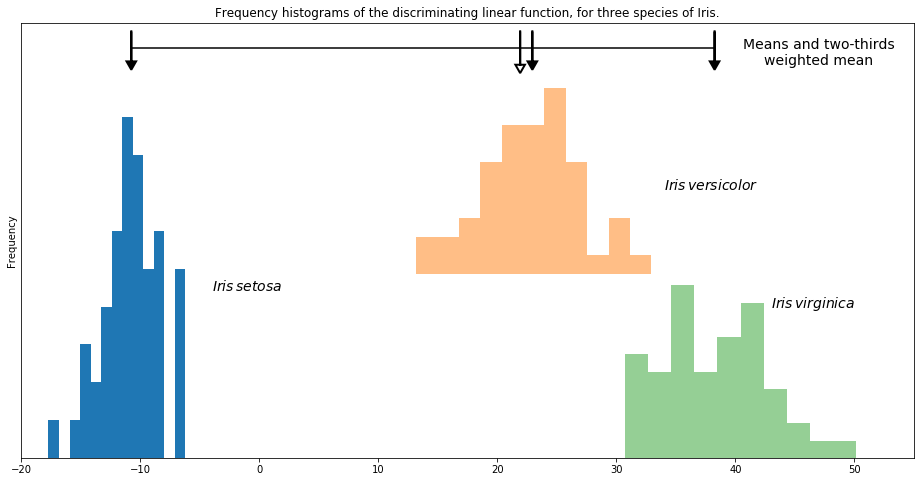

In [41]:
axhist = compounds.setosa.plot.hist(bins=13, normed=True, figsize=(16, 8))
axhist.hist(compounds.versicolor, bins=11, alpha=.5, normed=True, bottom=.11)
axhist.hist(compounds.virginica, bins=10, alpha=.5, normed=True)

for mean in compounds_mean:
    axhist.arrow(mean, .255, 0, -.018,
                 head_width=.8, head_length=.005, fc="k", ec="k", lw=2)
axhist.arrow((compounds_mean.setosa + 2 * compounds_mean.virginica) / 3,
             .255, 0, -.02,
             head_width=.8, head_length=.005, fc="w", ec="k", lw=2)
axhist.plot([compounds_mean.setosa, compounds_mean.virginica],
            [.245, .245], "k")

axhist.text(-4, .1, r"$Iris \, setosa$", size=14)
axhist.text(34, .16, r"$Iris \, versicolor$", size=14)
axhist.text(43, .09, r"$Iris \, virginica$", size=14)
axhist.text(47, .235, "Means and two-thirds\nweighted mean", size=14,
            horizontalalignment="center")

axhist.set(xlim=[-20, 55], ylim=[0, .26], yticks=[],
          title="Frequency histograms of the discriminating linear function, "
                "for three species of Iris.");

Actually, *Iris versicolor* and *Iris virginica* aren't linearly separable at all, as the convex hull of their raw 4-dimensional data overlaps. That can be seen with the $34$th *Iris versicolor* entry (row index $33$, as they start with zero), which happens to be inside the *Iris virginica* convex hull. We can get a subset of the latter hull formed by the entries whose row indices are $(0, 6, 8, 33, 34)$, such hull still contains that *Iris versicolor* entry:

In [42]:
entry = table1.versicolor.iloc[33]
subset = table1.virginica.iloc[[0, 6, 8, 33, 34]]
hull = spatial.ConvexHull(subset.append(entry))
entry.values.tolist() in hull.points[hull.vertices].tolist()

False

The above tells us the chosen *Iris versicolor* entry isn't a hull vertex, so it's inside the convex hull created with some selected *Iris virginica* data. Therefore, the raw data isn't linearly separable.

## How about the linear regression?

It worth noticing that the previous result isn't the coefficient vector one would get from using the $-5:1:4$ ratio numbers as the $y^{(g)}$ regressand values in a linear regression:

In [43]:
bold_x_full = iris.assign(bias=1).iloc[:,range(-1, 4)]
y_full = np.repeat([-5, 1, 4], 50).reshape(150, 1)
beta3 = np.linalg.pinv(bold_x_full) @ y_full
b3_lambda = beta3[1:] / beta3[1] * lambda3[0]
b3_lambda

matrix([[ -3.30899768],
        [ -5.26148702],
        [  8.4298788 ],
        [ 12.39881434]])

The scale factor was normalized to keep the same sepal length coefficient. That normalization lets the linear regression give the same result for any global scale factor applied to the $y^{(g)}$, and also to any global constant added to it.

The analysis of variance of this new result (with $49$ degrees of freedom for each group) is:

In [44]:
b3_compounds = pd.DataFrame([(dframe @ b3_lambda).flat for dframe in dframes],
                            index=["virginica", "versicolor", "setosa"]).T
b3_compounds_mean = b3_compounds.mean()
b3_compounds_ss = ((b3_compounds - b3_compounds_mean) ** 2).sum()
b3_compounds_ms = b3_compounds_ss / (n - 1)
pd.DataFrame([b3_compounds_mean, b3_compounds_ss, b3_compounds_ms,
              np.sqrt(b3_compounds_ms)],
              index=["Mean", "Sum of squares", "Mean square",
                     "Standard deviation"]).T

,Mean,Sum of squares,Mean square,Standard deviation
virginica,34.475346,1005.684195,20.524167,4.530361
versicolor,18.135582,887.181058,18.105736,4.255084
setosa,-19.226629,485.167815,9.901384,3.146646


In [45]:
b3_vi_ve = b3_compounds_mean.virginica - b3_compounds_mean.versicolor
b3_ve_se = b3_compounds_mean.versicolor - b3_compounds_mean.setosa
b3_prop = b3_ve_se / b3_vi_ve
pd.DataFrame([b3_vi_ve, b3_ve_se, b3_prop],
             columns=[""],
             index=[r"$\bar{X}^{(vi)} - \bar{X}^{(ve)}$",
                    r"$\bar{X}^{(ve)} - \bar{X}^{(se)}$",
                    r"$1:$"])

,
$\bar{X}^{(vi)} - \bar{X}^{(ve)}$,16.339764
$\bar{X}^{(ve)} - \bar{X}^{(se)}$,37.362211
$1:$,2.286582


Related Wikipedia links:

* [Coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* [Discriminant function analysis](https://en.wikipedia.org/wiki/Discriminant_function_analysis)
* [F-distribution](https://en.wikipedia.org/wiki/F-distribution)
* [Fisher's z-distribution](https://en.wikipedia.org/wiki/Fisher%27s_z-distribution)
* [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set)
* [Linear discriminant analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)
* [Linear regression](https://en.wikipedia.org/wiki/Linear_regression)
* [Moore–Penrose pseudoinverse](https://en.wikipedia.org/wiki/Moore–Penrose_pseudoinverse)
* [One-way analysis of variance](https://en.wikipedia.org/wiki/One-way_analysis_of_variance)
* [Ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares)
* [Ploidy](https://en.wikipedia.org/wiki/Ploidy)
* [Polyploid](https://en.wikipedia.org/wiki/Polyploid)
* [Pooled variance](https://en.wikipedia.org/wiki/Pooled_variance)